In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn

from einops import rearrange, reduce, repeat

import os
import itertools

plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
plt.rc("font", family='stixgeneral', size=14)
plt.rc("axes", facecolor=(1, .99, .95), titlesize=18)
plt.rc("mathtext", fontset='cm')

In [ ]:
!git clone https://github.com/james-simon/feature_recombination.git

import sys
sys.path.append('/content/feature_recombination')

import feature_recombination
from feature_recombination.data import ImageData
from feature_recombination.kernels import GaussianKernel
from feature_recombination.feature_decomp import generate_fra_monomials, Monomial
from feature_recombination.plotting.image_plotting import show_img
from feature_recombination.utils import ensure_torch, get_standard_tools
from feature_recombination.analysis.independence_tests import independentize_data, eigvecs_to_independent
from feature_recombination.analysis.gaussianity_tests import gaussianize_data, eigvecs_to_gaussian
from feature_recombination.analysis.independence_and_gaussian_tests import full_analysis
from feature_recombination.plotting.independence_and_gaussian_plotting import plot_full_pca_distributions, plot_heatmaps, plot_full_analysis

Cloning into 'feature_recombination'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 506 (delta 21), reused 29 (delta 14), pack-reused 461 (from 1)
Receiving objects: 100% (506/506), 90.35 KiB | 18.07 MiB/s, done.
Resolving deltas: 100% (324/324), done.


## SVHN Runs

In [ ]:
!git clone https://github.com/james-simon/feature_recombination.git

import sys
sys.path.append('/content/feature_recombination')

#looks horrible but can fix later
from feature_recombination.data import ImageData
from feature_recombination.kernels import GaussianKernel
from feature_recombination.feature_decomp import generate_fra_monomials, Monomial
from feature_recombination.plotting.image_plotting import show_img
from feature_recombination.utils.general import ensure_torch
from feature_recombination.utils.stats import get_standard_tools
import torch

Cloning into 'feature_recombination'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 220 (delta 11), reused 18 (delta 6), pack-reused 191 (from 1)
Receiving objects: 100% (220/220), 45.43 KiB | 3.49 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [ ]:
def get_image_dataset(n_train, n_test, dataset_name = 'cifar10', data_dir='data_dir', **kwargs):
    assert dataset_name in ['mnist', 'fmnist', 'cifar10', 'cifar100', 'svhn', 'imagenet32', 'imagenet64'], "Dataset not implemented"
    classes = kwargs.get("classes", None)
    imdata = ImageData(dataset_name, data_dir, classes=classes)
    X_train, y_train = imdata.get_dataset(n_train, get='train', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_test, y_test = imdata.get_dataset(n_train, get='test', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_train, y_train, X_test, y_test = [ensure_torch(t) for t in (X_train, y_train, X_test, y_test)]
    X_train = rearrange(X_train, 'Ntrain c h w -> Ntrain (c h w)')
    X_test = rearrange(X_test, 'Ntest c h w -> Ntest (c h w)')

    return X_train, y_train, X_test, y_test

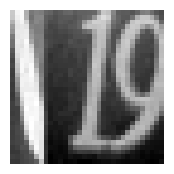

In [ ]:
classes = None
n_train = 10000
n_test = 1

X_train, y_train, _, _ = get_image_dataset(n_train, n_test, "svhn", classes=classes,
                                                       center=True, normalize=False)
X_train = reduce(X_train, 'N (3 s) -> N s', 'mean')

S = torch.linalg.svdvals(X_train)
X_train /= torch.sqrt((S**2).sum())
del S

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
im = show_img(X_train[0], ax=ax,) #shape=(3,32,32))
plt.show()

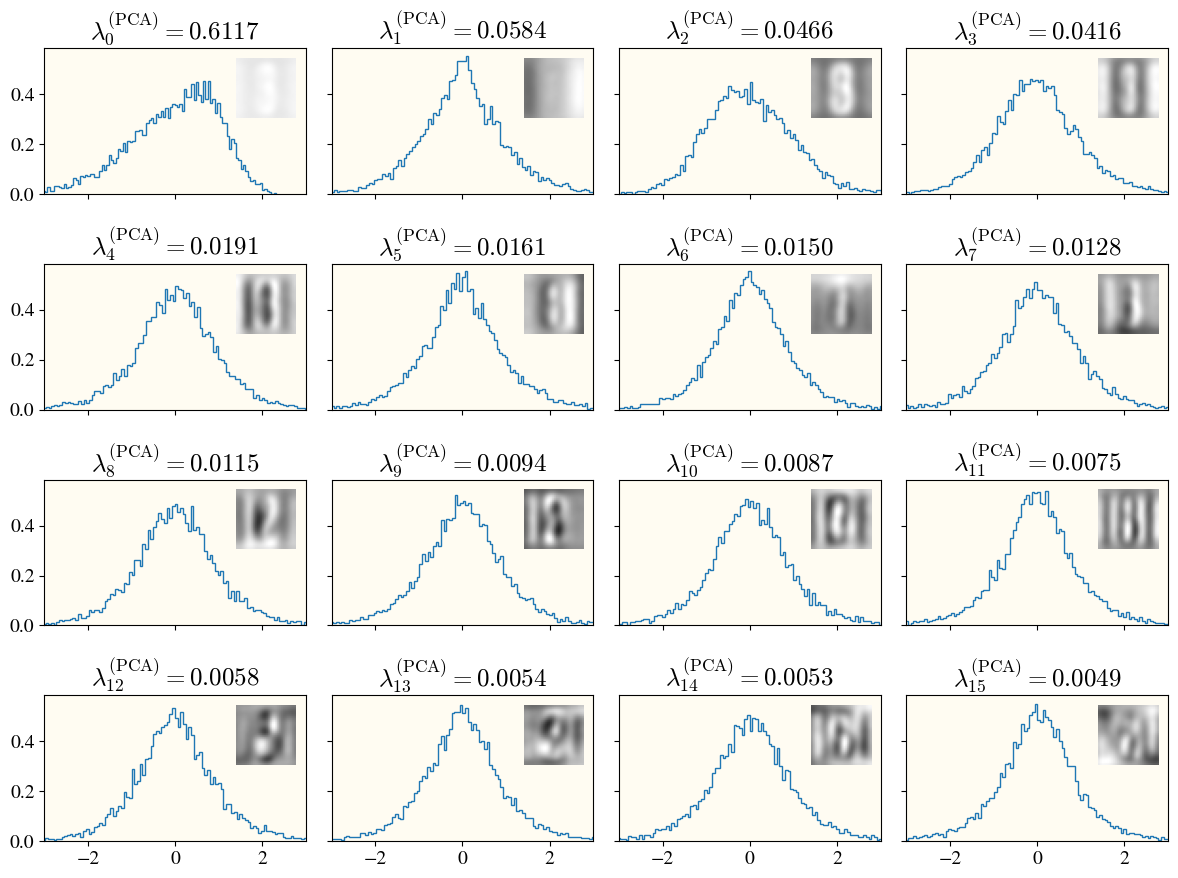

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

N, d = X_train.shape

U, S, Vt = torch.linalg.svd(X_train, full_matrices=False)
vmin, vmax = Vt[:64,:].min().item(), Vt[:64,:].max().item()
PC_ims = (Vt - vmin) / (vmax - vmin)

X = np.sqrt(N) * U @ torch.diag(S)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 9), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    xvar = S[i].item()**2
    Xi = X[:, i].cpu().numpy() / np.sqrt(xvar)
    Xi = Xi[np.abs(Xi) <= 3.1]
    ax.hist(Xi, bins=100,
            density=True, histtype='step', cumulative=False)

    ax.set_title(f"$\lambda^\mathrm{{(PCA)}}_{{{i}}}={xvar:.4f}$")
    ax.set_xlim(-3, 3)

plt.tight_layout()

for i, ax in enumerate(axes.flatten()):
    # Inset axes
    axins = inset_axes(ax, width=0.6, height=0.6, loc="upper right")
    im = show_img(PC_ims[i, :], ax=axins, vextent=(0, 1))

plt.show()

In [ ]:
kerneltype = GaussianKernel
N = 5000
bandwidth = 4

X_train, y_train, _, _ = get_image_dataset(n_train, n_test, "svhn", classes=classes,
                                                       center=True, normalize=False)
X_train = reduce(X_train, 'N (3 s) -> N s', 'mean')
N, d = X_train.shape

torch.cuda.empty_cache()
monomials, kernel, H, fra_eigvals, data_eigvals = get_standard_tools(X, kerneltype, bandwidth)
# kernel, H = result["K"], result["H"]
# data_eigvals = result["data_eigvals"]
# fra_eigvals, monomials = result["fra_eigvals"], result["monomials"]

eigvals, eigvecs = kernel.eigendecomp()
pdf, cdf, quartiles = kernel.kernel_function_projection(H)

print(eigvals.cpu().numpy()[:10])

[9.4143844e-01 3.3768989e-02 3.3986024e-03 2.7161341e-03 2.4255440e-03
 1.1094575e-03 9.8971603e-04 9.3468250e-04 8.6354767e-04 7.4238010e-04]


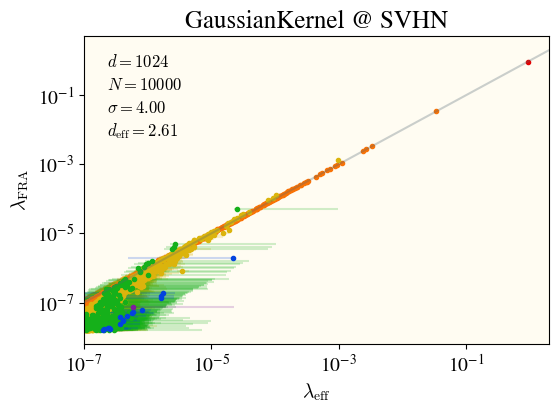

In [ ]:
degrees = [monomial.degree() for monomial in monomials]
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
dataname = "SVHN"

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

eigvals_cpu = eigvals.cpu().numpy()
eff_eigvals = quartiles[:, 1]
xerr = -np.array([quartiles[:, 0]-eff_eigvals, eff_eigvals-quartiles[:, 2]])
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    markers, caps, bars = ax.errorbar(eff_eigvals[idxs], fra_eigvals[idxs], xerr=xerr[:, idxs],
                 color=colors[degree%7], linestyle='', marker='.', alpha=1,)
    [bar.set_alpha(0.2) for bar in bars]

xmin, xmax = 1e-7, 2e0
xx = np.linspace(xmin, xmax, 10)
ax.set_xlim(xmin, xmax)
ax.plot(xx, xx, color='xkcd:slate', alpha=0.3, zorder=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'$\lambda_\mathrm{{eff}}$')
ax.set_ylabel(f'$\lambda_\mathrm{{FRA}}$')
d_eff = (data_eigvals.sum())**2/(data_eigvals**2).sum()
ax.set_title(f'GaussianKernel @ {dataname} post PC0 reduction')
text_kwargs = {'fontsize': 12, 'transform': ax.transAxes}
ax.text(0.05, 0.9, f'$d={d}$', **text_kwargs)
ax.text(0.05, 0.825, f'$N={N}$', **text_kwargs)
ax.text(0.05, 0.75, f'$\sigma={bandwidth:.2f}$', **text_kwargs)
ax.text(0.05, 0.675, f'$d_\mathrm{{eff}}={d_eff:.2f}$', **text_kwargs)
plt.show()

## MNIST Runs

In [ ]:
def get_image_dataset(n_train, n_test, dataset_name = 'cifar10', data_dir='data_dir', **kwargs):
    assert dataset_name in ['mnist', 'fmnist', 'cifar10', 'cifar100', 'svhn', 'imagenet32', 'imagenet64'], "Dataset not implemented"
    classes = kwargs.get("classes", None)
    imdata = ImageData(dataset_name, data_dir, classes=classes)
    X_train, y_train = imdata.get_dataset(n_train, get='train', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_test, y_test = imdata.get_dataset(n_train, get='test', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_train, y_train, X_test, y_test = [ensure_torch(t) for t in (X_train, y_train, X_test, y_test)]
    X_train = rearrange(X_train, 'Ntrain c h w -> Ntrain (c h w)')
    X_test = rearrange(X_test, 'Ntest c h w -> Ntest (c h w)')

    return X_train, y_train, X_test, y_test

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.28MB/s]


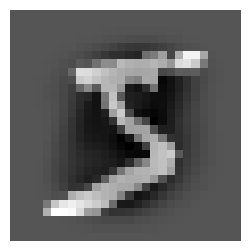

In [ ]:
classes = None
n_train = 10000
n_test = 1

X_train, y_train, _, _ = get_image_dataset(n_train, n_test, "mnist", classes=classes,
                                                       center=True, normalize=False)

S = torch.linalg.svdvals(X_train)
X_train /= torch.sqrt((S**2).sum())
del S

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
show_img(X_train[0], ax=ax,) #shape=(3,32,32))
plt.show()

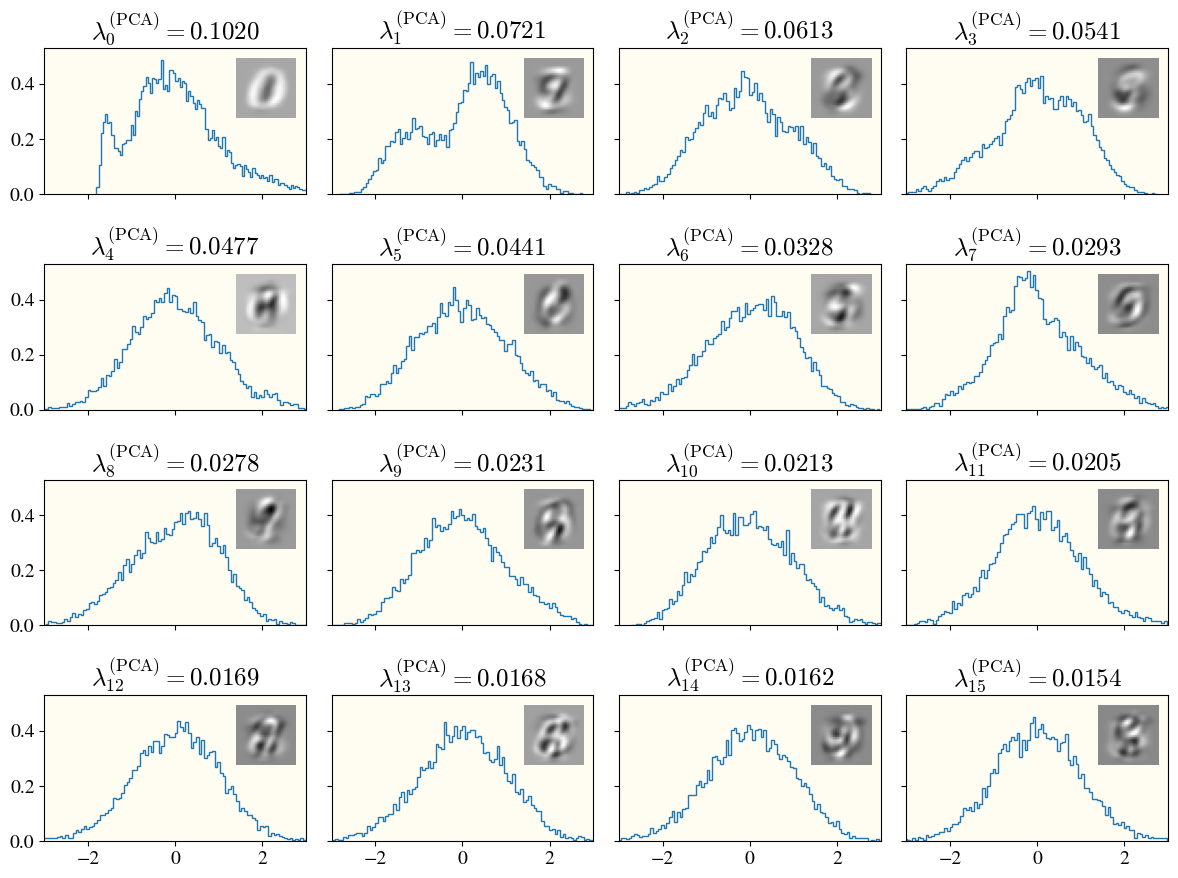

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

N, d = X_train.shape

U, S, Vt = torch.linalg.svd(X_train, full_matrices=False)
vmin, vmax = Vt[:64,:].min().item(), Vt[:64,:].max().item()
PC_ims = (Vt - vmin) / (vmax - vmin)

X = np.sqrt(N) * U @ torch.diag(S)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 9), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    xvar = S[i].item()**2
    Xi = X[:, i].cpu().numpy() / np.sqrt(xvar)
    Xi = Xi[np.abs(Xi) <= 3.1]
    ax.hist(Xi, bins=100,
            density=True, histtype='step', cumulative=False)

    ax.set_title(f"$\lambda^\mathrm{{(PCA)}}_{{{i}}}={xvar:.4f}$")
    ax.set_xlim(-3, 3)

plt.tight_layout()

for i, ax in enumerate(axes.flatten()):
    # Inset axes
    axins = inset_axes(ax, width=0.6, height=0.6, loc="upper right")
    im = show_img(PC_ims[i, :], ax=axins, vextent=(0, 1))

plt.show()

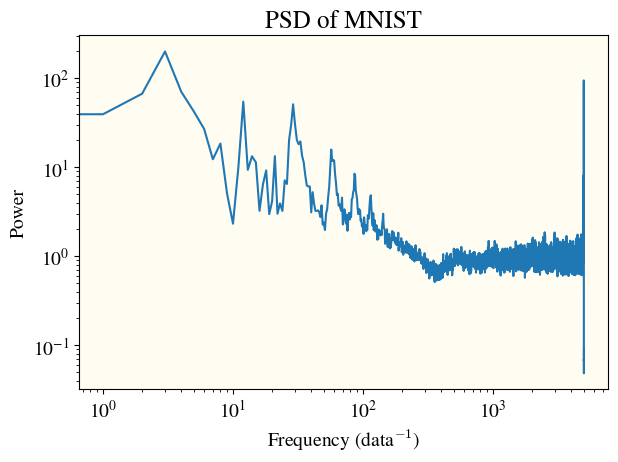

In [ ]:
img = X_train.cpu().numpy()
# imgsz = int(np.sqrt(int(len(img))))
# img = img.reshape(imgsz, imgsz).cpu().numpy()
f_transform = np.fft.fft2(img)
f_shifted = np.fft.fftshift(f_transform)
psd2D = np.abs(f_shifted)**2

# Create frequency radius array
y, x = np.indices(psd2D.shape)
center = np.array(psd2D.shape) // 2
r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
r = r.astype(np.int32)

# Radial average
tbin = np.bincount(r.ravel(), psd2D.ravel())
nr = np.bincount(r.ravel())
radial_psd = tbin / np.maximum(nr, 1)

# Plot frequency vs. power
freqs = np.arange(len(radial_psd))  # Pixel frequency units
plt.plot(freqs, radial_psd)
plt.yscale('log')
plt.xlabel(f'Frequency (data$^{{-1}}$)')
plt.ylabel('Power')
plt.title('PSD of MNIST')
# plt.grid(True)
plt.tight_layout()
plt.xscale("log")
plt.show()

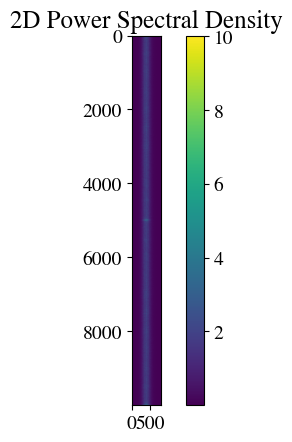

In [ ]:
# Power Spectral Density (magnitude squared)
psd2D = np.abs(f_shifted)**2

# Plot 2D PSD (log scale for visibility)
plt.imshow(np.log1p(psd2D), cmap='viridis')
plt.title('2D Power Spectral Density')
plt.colorbar()
plt.show()

In [ ]:
kerneltype = GaussianKernel
N = 5000
bandwidth = 4

X_train, y_train, _, _ = get_image_dataset(n_train, n_test, "mnist", classes=classes,
                                                       center=True, normalize=False)

N, d = X_train.shape

torch.cuda.empty_cache()
monomials, kernel, H, fra_eigvals, data_eigvals = get_standard_tools(X, kerneltype, bandwidth)
# kernel, H = result["K"], result["H"]
# data_eigvals = result["data_eigvals"]
# fra_eigvals, monomials = result["fra_eigvals"], result["monomials"]

eigvals, eigvecs = kernel.eigendecomp()
pdf, cdf, quartiles = kernel.kernel_function_projection(H)

print(eigvals.cpu().numpy()[:10])

[0.93964505 0.00595579 0.00424325 0.00357689 0.00316945 0.00279578
 0.0025981  0.00192764 0.00172021 0.0016354 ]


[0.0006706  0.00248588]
[1.70413318e-05 1.69699222e-03]
[5.25025155e-06 2.41804808e-04]
[7.18587762e-06 5.40438323e-05]
[6.43965291e-06 3.61431139e-05]


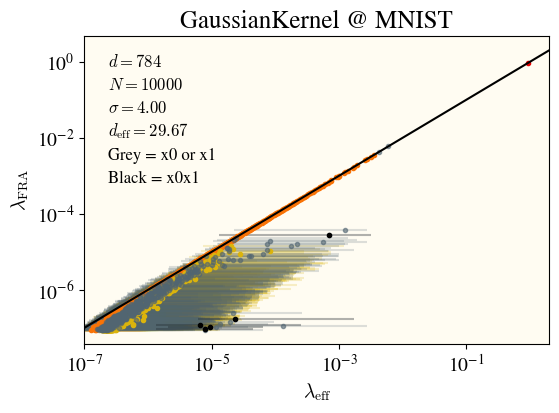

In [ ]:
degrees = [monomial.degree() for monomial in monomials]
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
colorx0x1 = 'xkcd:slate'
dataname = "MNIST"
show_monomial = [0, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

x0x1idxs = []
for monomial in monomials:
    if (0 in monomial.keys() or 1 in monomial.keys()):
        idxs = np.where(np.array(monomial) == monomials)[0][0]
        x0x1idxs.append(idxs)

eigvals_cpu = eigvals.cpu().numpy()
eff_eigvals = quartiles[:, 1]
xerr = -np.array([quartiles[:, 0]-eff_eigvals, eff_eigvals-quartiles[:, 2]])
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    mask = ~np.isin(idxs, x0x1idxs)
    idxs = np.unique(idxs)[mask]
    markers, caps, bars = ax.errorbar(eff_eigvals[idxs], fra_eigvals[idxs], xerr=xerr[:, idxs],
                 color=colors[degree%7], linestyle='', marker='.', alpha=1,)
    [bar.set_alpha(0.2) for bar in bars]

markers, caps, bars = ax.errorbar(eff_eigvals[x0x1idxs], fra_eigvals[x0x1idxs], xerr=xerr[:, x0x1idxs],
                 color=colorx0x1, linestyle='', marker='.', alpha=0.6,)
[bar.set_alpha(0.2) for bar in bars]

if show_monomial is not None:
    for monomial in monomials:
        if np.all([show in monomial.keys() for show in show_monomial]):
            idx = np.where(np.array(monomial) == monomials)[0][0]
            print(xerr[:, idx])
            # print(xerr[:, x0x1idxs])
            markers, caps, bars = ax.errorbar(eff_eigvals[idx], fra_eigvals[idx], xerr=np.array(xerr[:, idx].reshape(2, -1)),
                 color='xkcd:black', linestyle='', marker='.', alpha=1,)
            [bar.set_alpha(0.2) for bar in bars]


xmin, xmax = 1e-7, 2e0
xx = np.linspace(xmin, xmax, 10)
ax.set_xlim(xmin, xmax)
ax.plot(xx, xx, color='xkcd:black', alpha=1, zorder=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'$\lambda_\mathrm{{eff}}$')
ax.set_ylabel(f'$\lambda_\mathrm{{FRA}}$')
d_eff = (data_eigvals.sum())**2/(data_eigvals**2).sum()
ax.set_title(f'GaussianKernel @ {dataname}')
text_kwargs = {'fontsize': 12, 'transform': ax.transAxes}
ax.text(0.05, 0.9, f'$d={d}$', **text_kwargs)
ax.text(0.05, 0.825, f'$N={N}$', **text_kwargs)
ax.text(0.05, 0.75, f'$\sigma={bandwidth:.2f}$', **text_kwargs)
ax.text(0.05, 0.675, f'$d_\mathrm{{eff}}={d_eff:.2f}$', **text_kwargs)
ax.text(0.05, 0.6, f"Grey = x0 or x1", **text_kwargs)
ax.text(0.05, 0.525, f"Black = x0x1", **text_kwargs)
plt.show()

In [ ]:
def lookup_monomial_idx(monomials, monomial):
    for i, mon in enumerate(monomials):
        if mon == monomial:
            return i
    return None

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flat

plot_monomial = [{4:1,8:1}, {0:3}, {0:2, 1:1}, {0:4}, {0:3, 1:1}, {0:4, 1:1}]
# plot_monomial = [{0:3, 1:1}, {0:1}, {1:1}, {2:1, 1:1, 3:1}, {2:1, 3:1, 4:1}, {0:4}]
for i, ax in enumerate(axes):
    monomial_idx = lookup_monomial_idx(monomials, plot_monomial[i])
    ax.set_title(str(Monomial(plot_monomial[i])))
    if monomial_idx is None:
        continue
    monomial = monomials[monomial_idx]
    ax.scatter(eigvals, cdf[monomial_idx], marker='.')
    ax.axvline(quartiles[monomial_idx, 0], color='gray', ls='--')
    ax.axvline(quartiles[monomial_idx, 1], color='gray', ls='--')
    ax.axvline(quartiles[monomial_idx, 2], color='gray', ls='--')
    ax.axvline(fra_eigvals[monomial_idx], color='red', ls='-', alpha=0.4)

    ax.set_xscale('log')

plt.tight_layout()
plt.show()

### trying to see what the distribution for x0x1 looks like

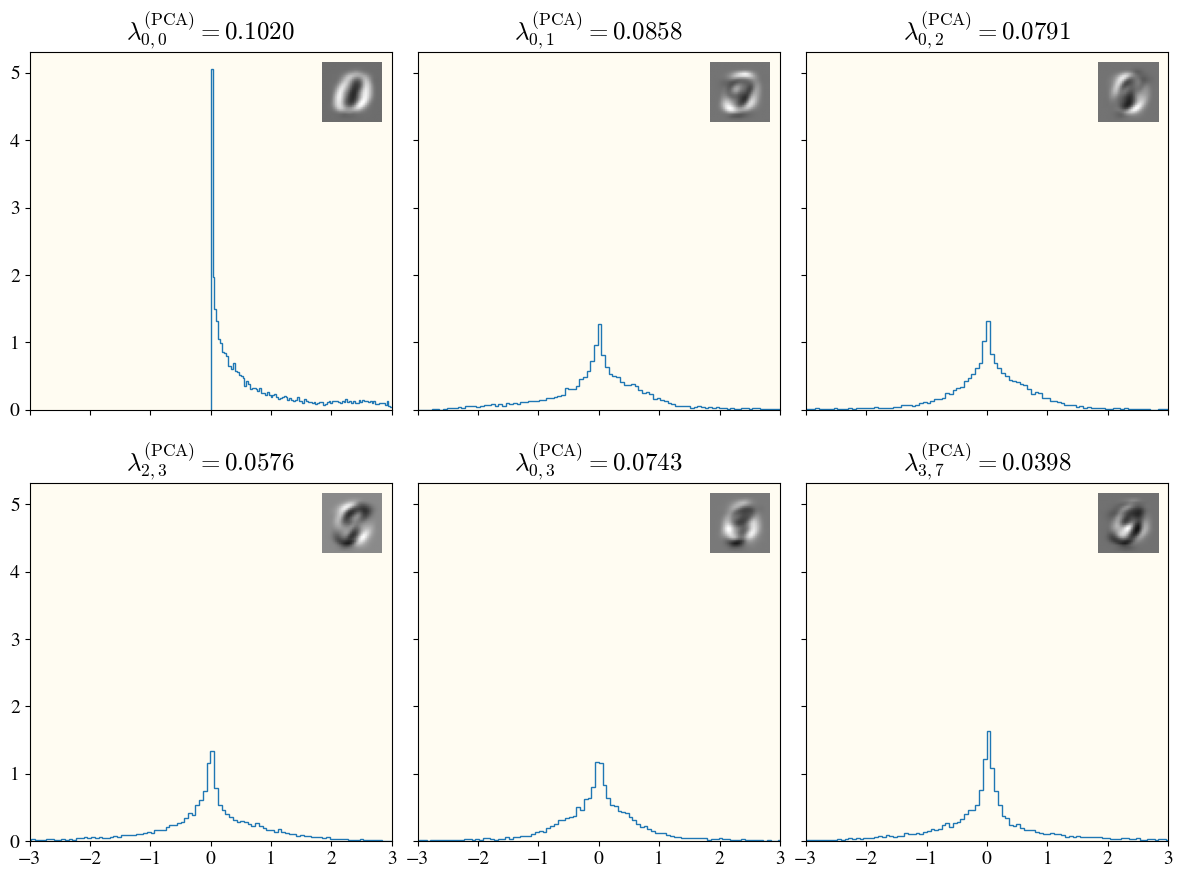

In [ ]:
N, d = X_train.shape

U, S, Vt = torch.linalg.svd(X_train, full_matrices=False)
vmin, vmax = Vt[:64,:].min().item(), Vt[:64,:].max().item()
PC_ims = (Vt - vmin) / (vmax - vmin)

X = np.sqrt(N) * U @ torch.diag(S)
# X = np.sqrt(N) * X_train @ Vt.T

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 9), sharex=True, sharey=True)

pointwise_correlations = [[0, 0], [0, 1], [0, 2], [2, 3], [0, 3], [3, 7]]

for i, ax in enumerate(axes.flatten()):
    idx1, idx2 = pointwise_correlations[i][0], pointwise_correlations[i][1]
    xvar1, xvar2 = S[idx1].item()**2, S[idx2].item()**2
    Xij = X[:, idx1].cpu().numpy() * X[:, idx2].cpu().numpy() / np.sqrt(xvar1*xvar2)
    Xij = Xij[np.abs(Xij) <= 3.1]
    ax.hist(Xij, bins=100,
            density=True, histtype='step', cumulative=False)

    ax.set_title(f"$\lambda^\mathrm{{(PCA)}}_{{{idx1},{idx2}}}={S[idx1].item()*S[idx2].item()/torch.sum(S**2):.4f}$")
    ax.set_xlim(-3, 3)

plt.tight_layout()

for i, ax in enumerate(axes.flatten()):
    idx1, idx2 = pointwise_correlations[i][0], pointwise_correlations[i][1]
    axins = inset_axes(ax, width=0.6, height=0.6, loc="upper right")
    im = show_img(PC_ims[idx1, :]*PC_ims[idx2, :], ax=axins, vextent=(0, 1))

plt.show()

## Testing MNIST against gaussian/independent transformations

In [ ]:
!git clone https://github.com/james-simon/feature_recombination.git

import sys
sys.path.append('/content/feature_recombination')

#looks horrible but can fix later
import feature_recombination
from feature_recombination.data import ImageData
from feature_recombination.kernels import GaussianKernel
from feature_recombination.feature_decomp import generate_fra_monomials, Monomial
from feature_recombination.plotting.image_plotting import show_img
from feature_recombination.utils.general import ensure_torch
from feature_recombination.utils.stats import get_standard_tools
from feature_recombination.analysis.independence_tests import independentize_data, eigvecs_to_independent
from feature_recombination.analysis.gaussianity_tests import gaussianize_data, eigvecs_to_gaussian
from feature_recombination.analysis.independence_and_gaussian_tests import full_analysis
from feature_recombination.plotting.independence_and_gaussian_plotting import plot_full_pca_distributions, plot_heatmaps, plot_full_analysis
import torch

In [ ]:
def get_train_test_dataset(n_train, n_test, dataset_name = 'cifar10', data_dir='data_dir', **kwargs):
    assert dataset_name in ['mnist', 'fmnist', 'cifar10', 'cifar100', 'svhn', 'imagenet32', 'imagenet64'], "Dataset not implemented"
    classes = kwargs.get("classes", None)
    imdata = ImageData(dataset_name, data_dir, classes=classes)
    X_train, y_train = imdata.get_dataset(n_train, get='train', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_test, y_test = imdata.get_dataset(n_train, get='test', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_train, y_train, X_test, y_test = [ensure_torch(t) for t in (X_train, y_train, X_test, y_test)]
    X_train = rearrange(X_train, 'Ntrain c h w -> Ntrain (c h w)')
    X_test = rearrange(X_test, 'Ntest c h w -> Ntest (c h w)')

    return X_train, y_train, X_test, y_test

In [ ]:
classes = None
n_train = 10000
n_test = 1

X_train, y_train, _, _ = get_train_test_dataset(n_train, n_test, "mnist",
                                                       center=True, normalize=False)

S = torch.linalg.svdvals(X_train)
X_train /= torch.sqrt((S**2).sum())
del S

# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# show_img(X_train[0], ax=ax,) #shape=(3,32,32))
# plt.show()

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.52MB/s]


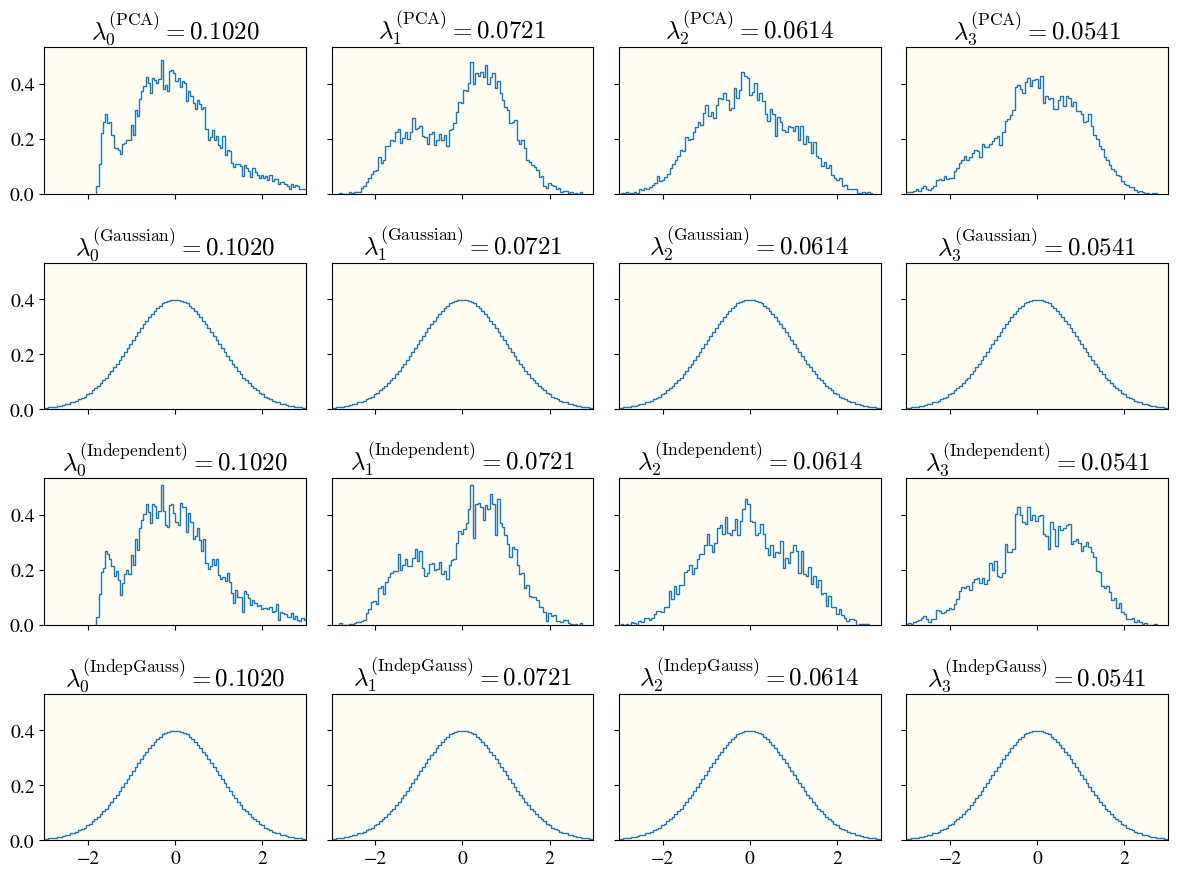

In [ ]:
eigvecs, eigvecs_gaussian, eigvecs_independent, eigvecs_indep_gaussian, Vt = plot_full_pca_distributions(X_train)

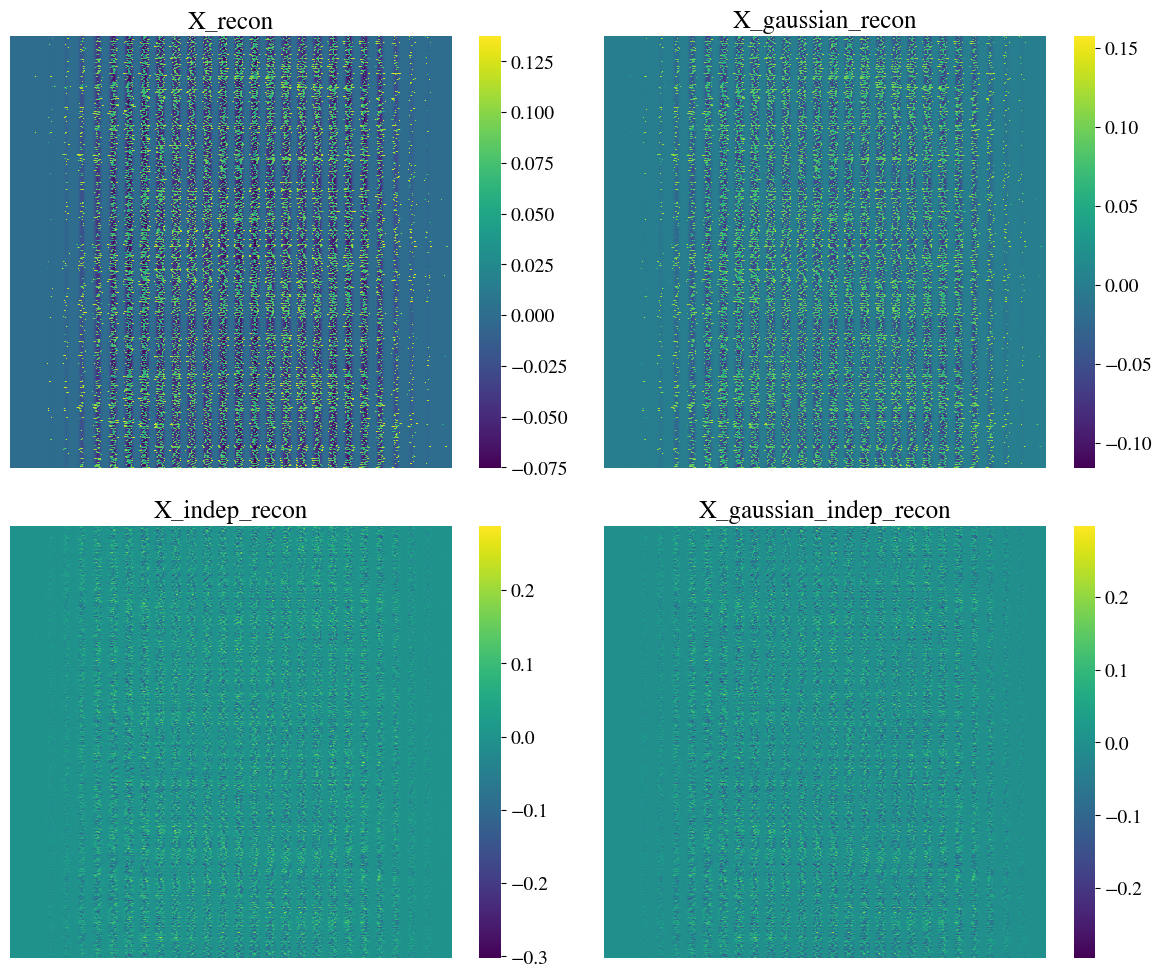

In [ ]:
_ = plot_heatmaps(eigvecs, eigvecs_gaussian, eigvecs_independent, eigvecs_indep_gaussian, Vt)

In [ ]:
kerneltype = GaussianKernel
kernel_width = 4
classes = None
n_train = 10000
top_fra_eigmode = 3000
n_test = 1

X_train, y_train, _, _ = get_train_test_dataset(n_train, n_test, "mnist", classes=classes,
                                                       center=True, normalize=False)
X_train = ensure_torch(X_train)
full_dict = full_analysis(X_train, kerneltype, kernel_width, top_fra_eigmode)
normeigvals = full_dict["Normal"]["eigvals"].cpu().numpy()[:10]
gaussianeigvals = full_dict["Gaussian"]["eigvals"].cpu().numpy()[:10]
independenteigvals = full_dict["Independent"]["eigvals"].cpu().numpy()[:10]
gaussianindependenteigvals = full_dict["Gaussian Independent"]["eigvals"].cpu().numpy()[:10]
print(f"Normal: {normeigvals}")
print(f"Gaussianized data: {gaussianeigvals}")
print(f"Independentized data: {independenteigvals}")
print(f"Gaussian independent: {gaussianindependenteigvals}")

Normal: [0.93964515 0.00595579 0.00424327 0.00357689 0.00316944 0.00279578
 0.00259811 0.00192765 0.00172021 0.00163542]
Gaussianized data: [0.93960432 0.00604679 0.00423303 0.00357176 0.00317548 0.00276042
 0.00259132 0.00192431 0.00171851 0.00163337]
Independentized data: [0.9396132  0.00606384 0.00417199 0.00355604 0.00308978 0.00280043
 0.00264632 0.0018854  0.00169794 0.00164498]
Gaussian independent: [0.93959555 0.00591427 0.00419935 0.00357478 0.00315909 0.00278741
 0.00257772 0.00191931 0.00171384 0.00162896]


AttributeError: 'Tensor' object has no attribute 'kernel_width'

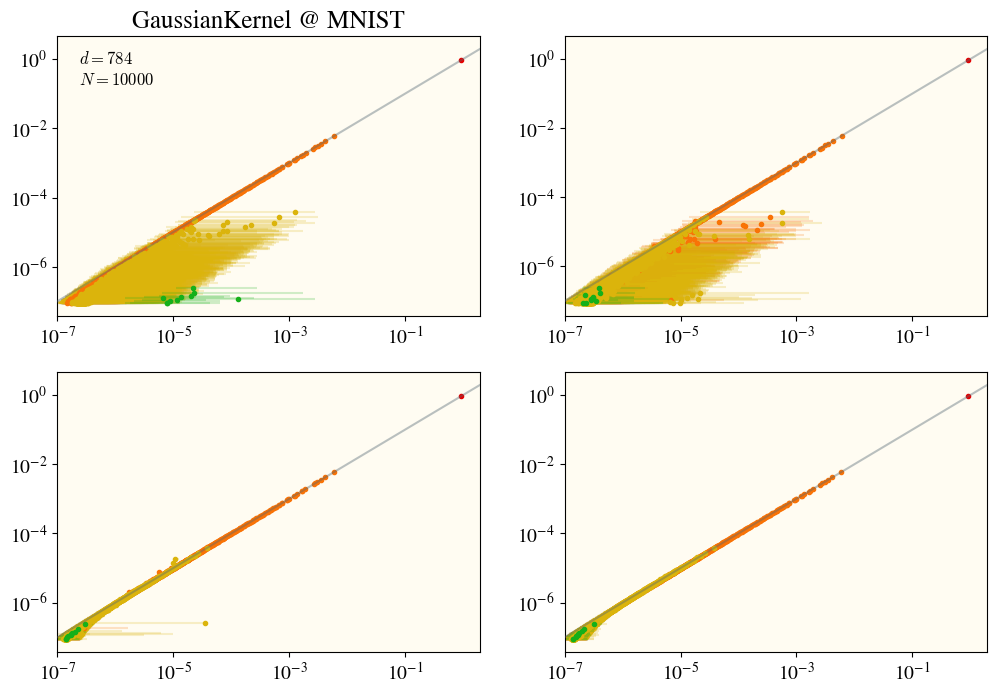

In [ ]:
N, d = X_train.shape
plot_full_analysis(full_dict, colors=['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"],
                        axes=None, d=d, N=N, kernelname="GaussianKernel", dataname="MNIST", kernel_width=kernel_width)

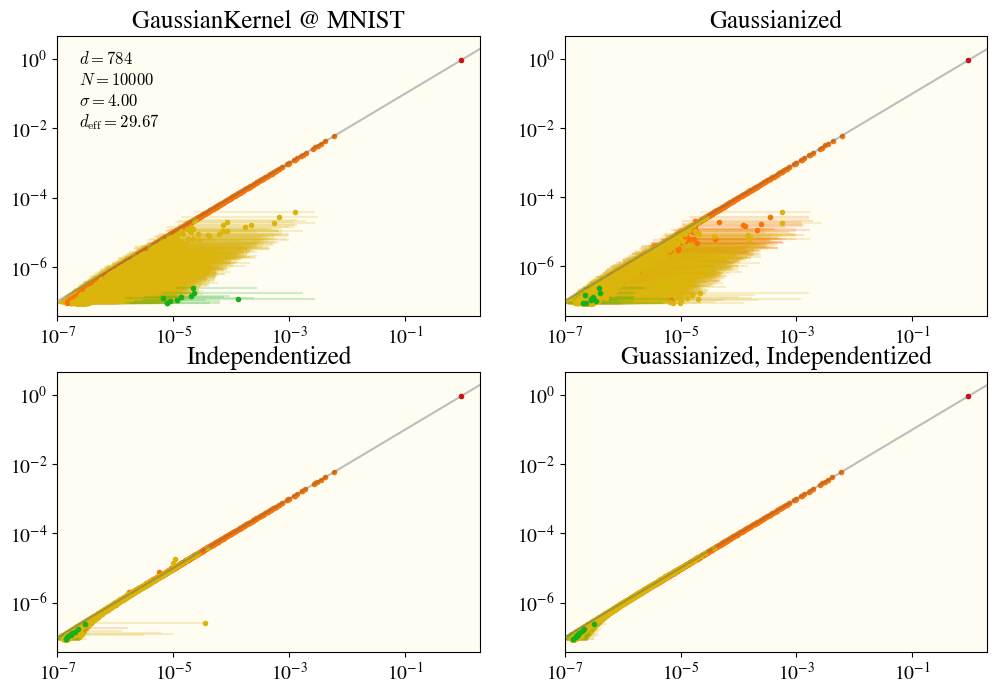

In [ ]:
N, d = X_train.shape
degrees = [monomial.degree() for monomial in full_dict["Normal"]["monomials"]]
colors=['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# eigvals_cpu = eigvals.cpu().numpy()
# eigvals_g_cpu = eigvals_g.cpu().numpy()
# eigvals_i_cpu = eigvals_i.cpu().numpy()
# eigvals_gi_cpu = eigvals_gi.cpu().numpy()
quartiles = full_dict["Normal"]["quartiles"]
quartiles_g = full_dict["Gaussian"]["quartiles"]
quartiles_i = full_dict["Independent"]["quartiles"]
quartiles_gi = full_dict["Gaussian Independent"]["quartiles"]
eff_eigvals = quartiles[:, 1]
eff_eigvals_g = quartiles_g[:, 1]
eff_eigvals_i = quartiles_i[:, 1]
eff_eigvals_gi = quartiles_gi[:, 1]
xerr = -np.array([quartiles[:, 0]-eff_eigvals, eff_eigvals-quartiles[:, 2]])
xerr_g = -np.array([quartiles_g[:, 0]-eff_eigvals_g, eff_eigvals_g-quartiles_g[:, 2]])
xerr_i = -np.array([quartiles_i[:, 0]-eff_eigvals_i, eff_eigvals_i-quartiles_i[:, 2]])
xerr_gi = -np.array([quartiles_gi[:, 0]-eff_eigvals_gi, eff_eigvals_gi-quartiles_gi[:, 2]])


xmin, xmax = 1e-7, 2e0
xx = np.linspace(xmin, xmax, 10)

def plot_eigvals(ax, eff_eigvals, fra_eigvals, xerr):
    for degree in np.unique(degrees):
        idxs = np.where(np.array(degrees) == degree)[0]
        markers, caps, bars = ax.errorbar(eff_eigvals[idxs], fra_eigvals[idxs], xerr=xerr[:, idxs],
                    color=colors[degree%7], linestyle='', marker='.', alpha=1,)
        [bar.set_alpha(0.2) for bar in bars]

    ax.set_xlim(xmin, xmax)
    ax.plot(xx, xx, color='xkcd:slate', alpha=0.4, zorder=4)
    ax.set_xscale('log')
    ax.set_yscale('log')

plot_eigvals(axes[0, 0], eff_eigvals, full_dict["Normal"]["fra_eigvals"], xerr)
plot_eigvals(axes[0, 1], eff_eigvals_g, full_dict["Gaussian"]["fra_eigvals"], xerr_g)
plot_eigvals(axes[1, 0], eff_eigvals_i, full_dict["Independent"]["fra_eigvals"], xerr_i)
plot_eigvals(axes[1, 1], eff_eigvals_gi, full_dict["Gaussian Independent"]["fra_eigvals"], xerr_gi)


d_eff = (full_dict["Normal"]["data_eigvals"].sum())**2/(full_dict["Normal"]["data_eigvals"]**2).sum()
ax = axes[0, 0]
ax.set_title(f'GaussianKernel @ MNIST')
text_kwargs = {'fontsize': 12, 'transform': ax.transAxes}
ax.text(0.05, 0.9, f'$d={d}$', **text_kwargs)
ax.text(0.05, 0.825, f'$N={N}$', **text_kwargs)
ax.text(0.05, 0.75, f'$\sigma={kernel_width:.2f}$', **text_kwargs)
ax.text(0.05, 0.675, f'$d_\mathrm{{eff}}={d_eff:.2f}$', **text_kwargs)
axes[0, 1].set_title(f'Gaussianized')
axes[1, 0].set_title(f'Independentized')
axes[1, 1].set_title(f'Guassianized, Independentized')
plt.show()

## Testing SVHN against gaussian/independent transformations

In [ ]:
!git clone https://github.com/james-simon/feature_recombination.git

import sys
sys.path.append('/content/feature_recombination')

#looks horrible but can fix later
import feature_recombination
from feature_recombination.data import ImageData
from feature_recombination.kernels import GaussianKernel
from feature_recombination.feature_decomp import generate_fra_monomials, Monomial
from feature_recombination.plotting.image_plotting import show_img
from feature_recombination.utils.general import ensure_torch
from feature_recombination.utils.stats import get_standard_tools
from feature_recombination.analysis.independence_tests import independentize_data, eigvecs_to_independent
from feature_recombination.analysis.gaussianity_tests import gaussianize_data, eigvecs_to_gaussian
from feature_recombination.analysis.independence_and_gaussian_tests import full_analysis
from feature_recombination.plotting.independence_and_gaussian_plotting import plot_full_pca_distributions, plot_heatmaps, plot_full_analysis
import torch

fatal: destination path 'feature_recombination' already exists and is not an empty directory.


In [ ]:
def get_train_test_dataset(n_train, n_test, dataset_name = 'cifar10', data_dir='data_dir', **kwargs):
    assert dataset_name in ['mnist', 'fmnist', 'cifar10', 'cifar100', 'svhn', 'imagenet32', 'imagenet64'], "Dataset not implemented"
    classes = kwargs.get("classes", None)
    imdata = ImageData(dataset_name, data_dir, classes=classes)
    X_train, y_train = imdata.get_dataset(n_train, get='train', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_test, y_test = imdata.get_dataset(n_train, get='test', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_train, y_train, X_test, y_test = [ensure_torch(t) for t in (X_train, y_train, X_test, y_test)]
    X_train = rearrange(X_train, 'Ntrain c h w -> Ntrain (c h w)')
    X_test = rearrange(X_test, 'Ntest c h w -> Ntest (c h w)')

    return X_train, y_train, X_test, y_test

In [ ]:
classes = None
n_train = 10000
n_test = 1

X_train, y_train, _, _ = get_train_test_dataset(n_train, n_test, "svhn",
                                                       center=True, normalize=False)

S = torch.linalg.svdvals(X_train)
X_train /= torch.sqrt((S**2).sum())
del S

# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# show_img(X_train[0], ax=ax,) #shape=(3,32,32))
# plt.show()

100%|██████████| 182M/182M [00:17<00:00, 10.4MB/s]
100%|██████████| 64.3M/64.3M [00:13<00:00, 4.91MB/s]


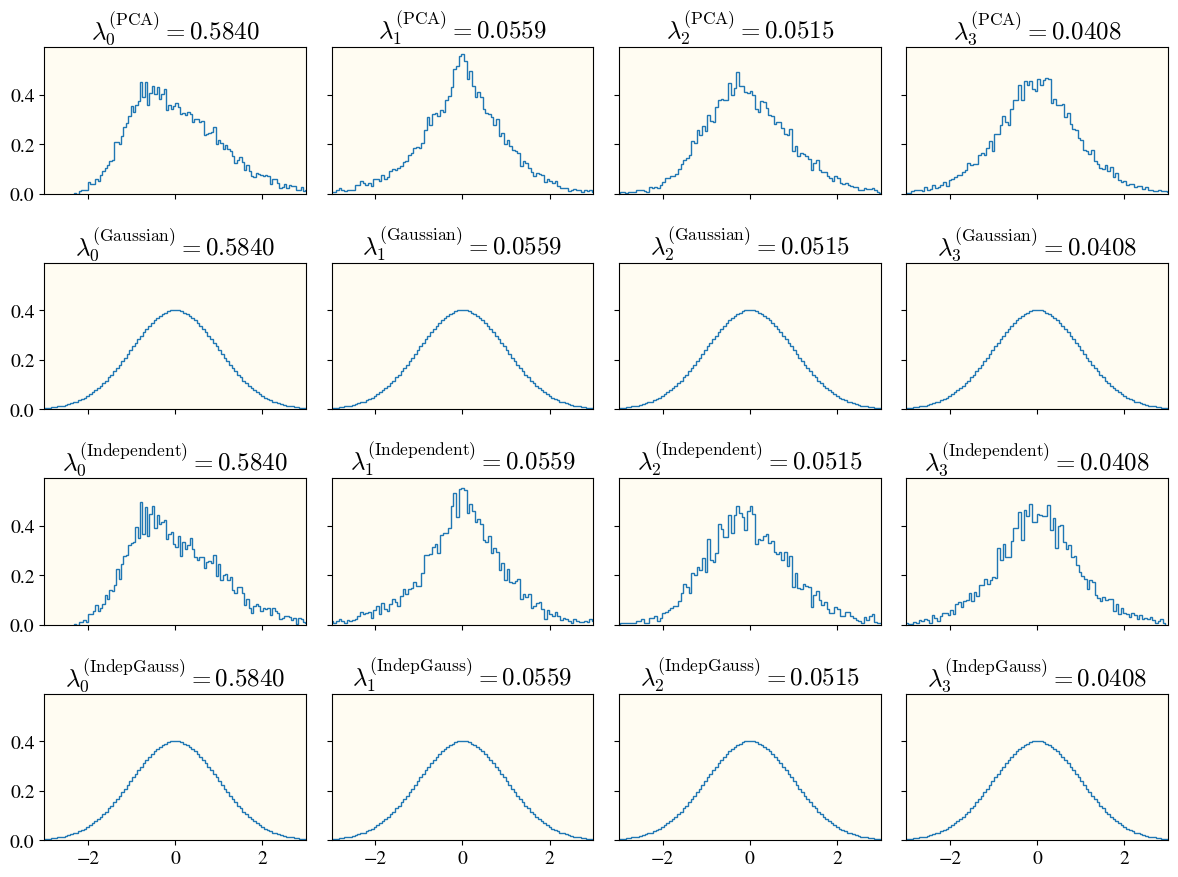

In [ ]:
eigvecs, eigvecs_gaussian, eigvecs_independent, eigvecs_indep_gaussian, Vt = plot_full_pca_distributions(X_train)

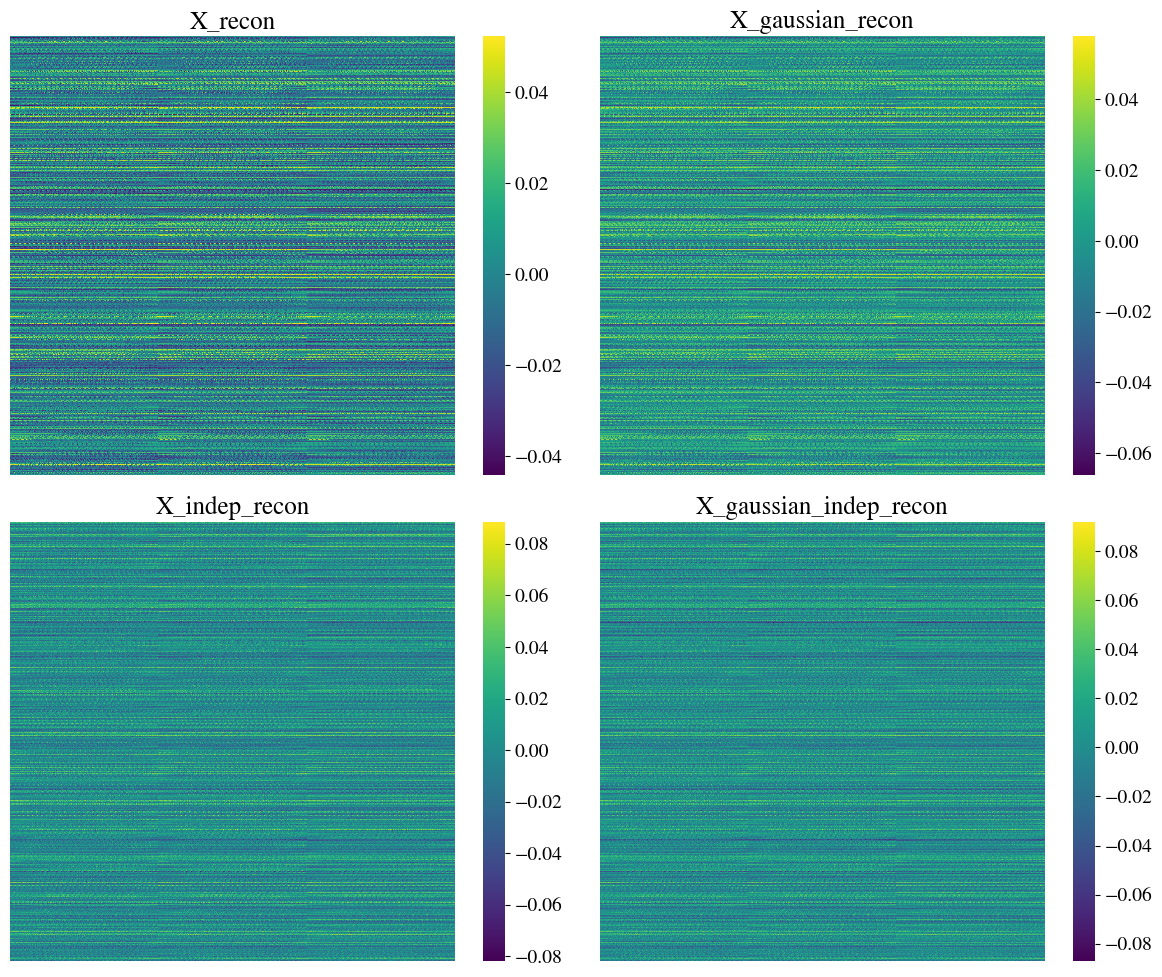

In [ ]:
_ = plot_heatmaps(eigvecs, eigvecs_gaussian, eigvecs_independent, eigvecs_indep_gaussian, Vt)

In [ ]:
kerneltype = GaussianKernel
kernel_width = 4
classes = None
n_train = 10000
top_fra_eigmode = 3000
n_test = 1

X_train, y_train, _, _ = get_train_test_dataset(n_train, n_test, "svhn", classes=classes,
                                                       center=True, normalize=False)
X_train = ensure_torch(X_train)
full_dict = full_analysis(X_train, kerneltype, kernel_width, top_fra_eigmode)
normeigvals = full_dict["Normal"]["eigvals"].cpu().numpy()[:10]
gaussianeigvals = full_dict["Gaussian"]["eigvals"].cpu().numpy()[:10]
independenteigvals = full_dict["Independent"]["eigvals"].cpu().numpy()[:10]
gaussianindependenteigvals = full_dict["Gaussian Independent"]["eigvals"].cpu().numpy()[:10]
print(f"Normal: {normeigvals}")
print(f"Gaussianized data: {gaussianeigvals}")
print(f"Independentized data: {independenteigvals}")
print(f"Gaussian independent: {gaussianindependenteigvals}")

Normal: [9.41270485e-01 3.23387669e-02 3.25122774e-03 2.99598771e-03
 2.37927472e-03 1.29538877e-03 1.06802293e-03 9.10400550e-04
 8.83820787e-04 8.15126866e-04]
Gaussianized data: [9.41205166e-01 3.21317252e-02 3.27318769e-03 3.01451751e-03
 2.39131445e-03 1.31880044e-03 1.08110025e-03 1.04758940e-03
 9.09845183e-04 8.26584798e-04]
Independentized data: [9.41179646e-01 3.19768871e-02 3.20677652e-03 2.97254853e-03
 2.47190389e-03 1.31846878e-03 1.11059181e-03 9.38653113e-04
 9.23071466e-04 8.07115870e-04]
Gaussian independent: [9.41197560e-01 3.20690762e-02 3.26038227e-03 3.00922081e-03
 2.39280793e-03 1.27476601e-03 1.09496032e-03 1.06879944e-03
 9.11100170e-04 8.26339520e-04]


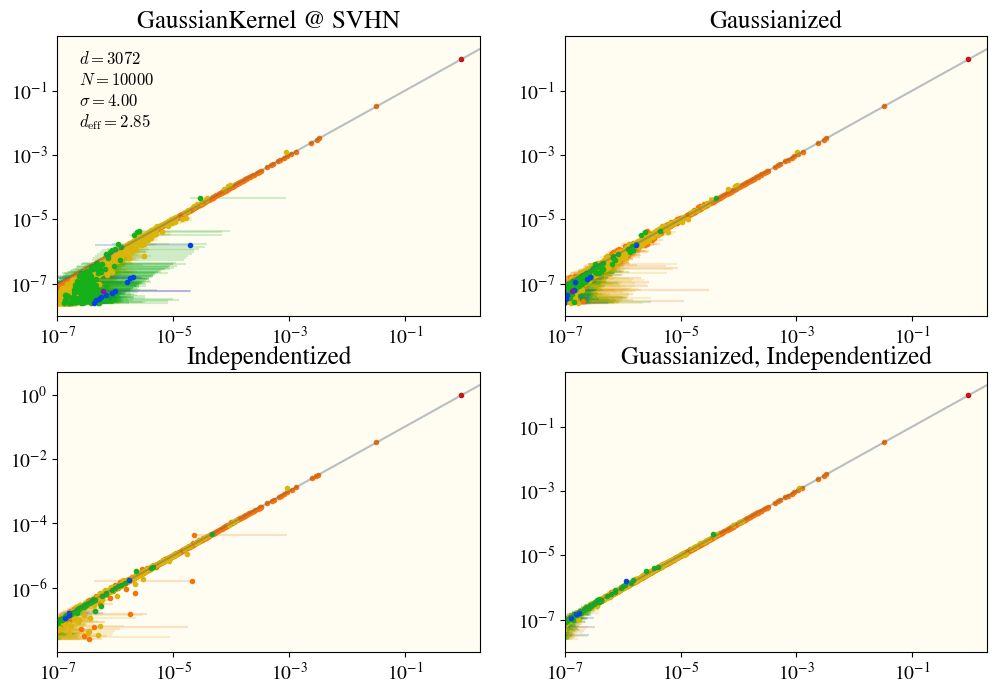

In [ ]:
N, d = X_train.shape
degrees = [monomial.degree() for monomial in full_dict["Normal"]["monomials"]]
colors=['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# eigvals_cpu = eigvals.cpu().numpy()
# eigvals_g_cpu = eigvals_g.cpu().numpy()
# eigvals_i_cpu = eigvals_i.cpu().numpy()
# eigvals_gi_cpu = eigvals_gi.cpu().numpy()
quartiles = full_dict["Normal"]["quartiles"]
quartiles_g = full_dict["Gaussian"]["quartiles"]
quartiles_i = full_dict["Independent"]["quartiles"]
quartiles_gi = full_dict["Gaussian Independent"]["quartiles"]
eff_eigvals = quartiles[:, 1]
eff_eigvals_g = quartiles_g[:, 1]
eff_eigvals_i = quartiles_i[:, 1]
eff_eigvals_gi = quartiles_gi[:, 1]
xerr = -np.array([quartiles[:, 0]-eff_eigvals, eff_eigvals-quartiles[:, 2]])
xerr_g = -np.array([quartiles_g[:, 0]-eff_eigvals_g, eff_eigvals_g-quartiles_g[:, 2]])
xerr_i = -np.array([quartiles_i[:, 0]-eff_eigvals_i, eff_eigvals_i-quartiles_i[:, 2]])
xerr_gi = -np.array([quartiles_gi[:, 0]-eff_eigvals_gi, eff_eigvals_gi-quartiles_gi[:, 2]])


xmin, xmax = 1e-7, 2e0
xx = np.linspace(xmin, xmax, 10)

def plot_eigvals(ax, eff_eigvals, fra_eigvals, xerr):
    for degree in np.unique(degrees):
        idxs = np.where(np.array(degrees) == degree)[0]
        markers, caps, bars = ax.errorbar(eff_eigvals[idxs], fra_eigvals[idxs], xerr=xerr[:, idxs],
                    color=colors[degree%7], linestyle='', marker='.', alpha=1,)
        [bar.set_alpha(0.2) for bar in bars]

    ax.set_xlim(xmin, xmax)
    ax.plot(xx, xx, color='xkcd:slate', alpha=0.4, zorder=4)
    ax.set_xscale('log')
    ax.set_yscale('log')

plot_eigvals(axes[0, 0], eff_eigvals, full_dict["Normal"]["fra_eigvals"], xerr)
plot_eigvals(axes[0, 1], eff_eigvals_g, full_dict["Gaussian"]["fra_eigvals"], xerr_g)
plot_eigvals(axes[1, 0], eff_eigvals_i, full_dict["Independent"]["fra_eigvals"], xerr_i)
plot_eigvals(axes[1, 1], eff_eigvals_gi, full_dict["Gaussian Independent"]["fra_eigvals"], xerr_gi)


d_eff = (full_dict["Normal"]["data_eigvals"].sum())**2/(full_dict["Normal"]["data_eigvals"]**2).sum()
ax = axes[0, 0]
ax.set_title(f'GaussianKernel @ SVHN')
text_kwargs = {'fontsize': 12, 'transform': ax.transAxes}
ax.text(0.05, 0.9, f'$d={d}$', **text_kwargs)
ax.text(0.05, 0.825, f'$N={N}$', **text_kwargs)
ax.text(0.05, 0.75, f'$\sigma={kernel_width:.2f}$', **text_kwargs)
ax.text(0.05, 0.675, f'$d_\mathrm{{eff}}={d_eff:.2f}$', **text_kwargs)
axes[0, 1].set_title(f'Gaussianized')
axes[1, 0].set_title(f'Independentized')
axes[1, 1].set_title(f'Guassianized, Independentized')
plt.show()

## Testing CIFAR100 against gaussian/independent transformations

In [ ]:
def get_train_test_dataset(n_train, n_test, dataset_name = 'cifar10', data_dir='data_dir', **kwargs):
    assert dataset_name in ['mnist', 'fmnist', 'cifar10', 'cifar100', 'svhn', 'imagenet32', 'imagenet64'], "Dataset not implemented"
    classes = kwargs.get("classes", None)
    imdata = ImageData(dataset_name, data_dir, classes=classes)
    X_train, y_train = imdata.get_dataset(n_train, get='train', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_test, y_test = imdata.get_dataset(n_train, get='test', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_train, y_train, X_test, y_test = [ensure_torch(t) for t in (X_train, y_train, X_test, y_test)]
    X_train = rearrange(X_train, 'Ntrain c h w -> Ntrain (c h w)')
    X_test = rearrange(X_test, 'Ntest c h w -> Ntest (c h w)')

    return X_train, y_train, X_test, y_test

In [ ]:
classes = None
n_train = 10000
n_test = 1

X_train, y_train, _, _ = get_train_test_dataset(n_train, n_test, "cifar100",
                                                       center=True, normalize=False)

S = torch.linalg.svdvals(X_train)
X_train /= torch.sqrt((S**2).sum())
del S

# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# show_img(X_train[0], ax=ax,) #shape=(3,32,32))
# plt.show()

100%|██████████| 169M/169M [00:06<00:00, 28.1MB/s]


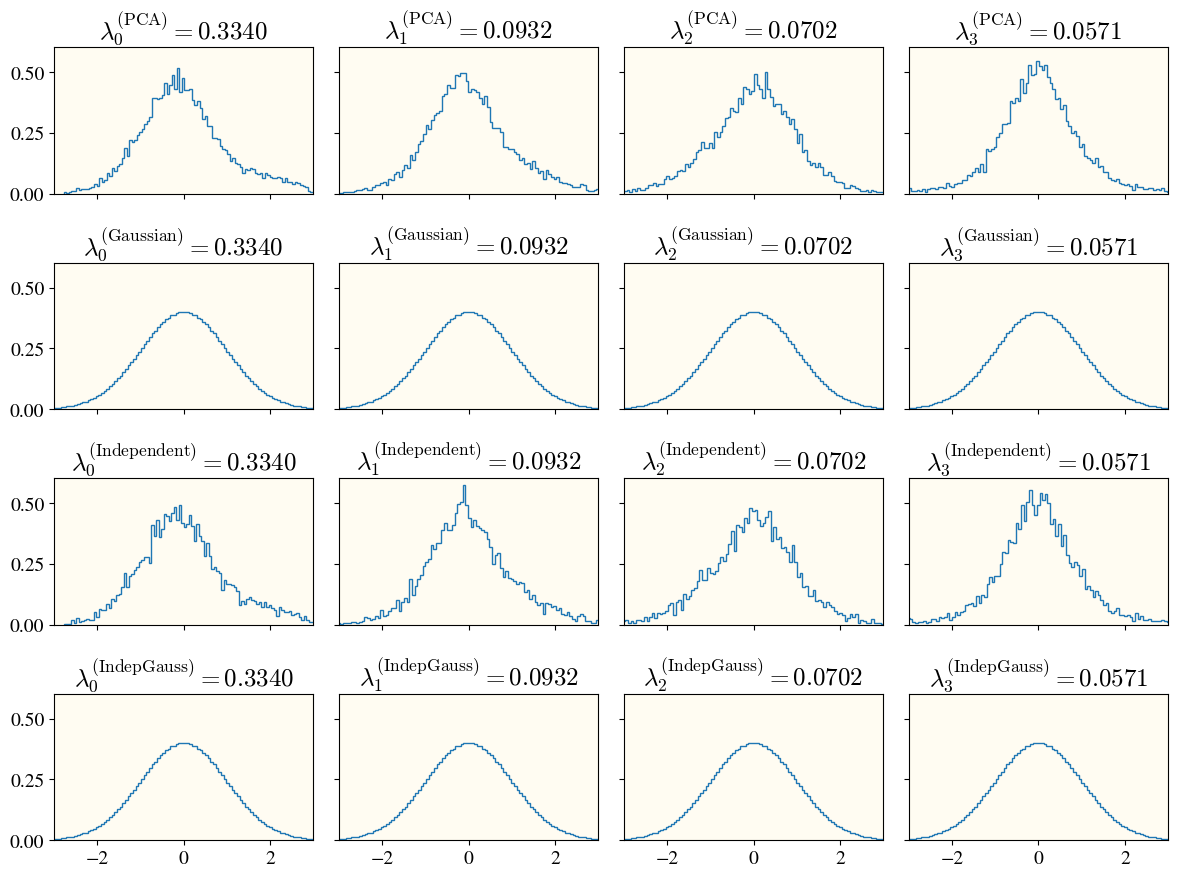

In [ ]:
eigvecs, eigvecs_gaussian, eigvecs_independent, eigvecs_indep_gaussian, Vt = plot_full_pca_distributions(X_train)

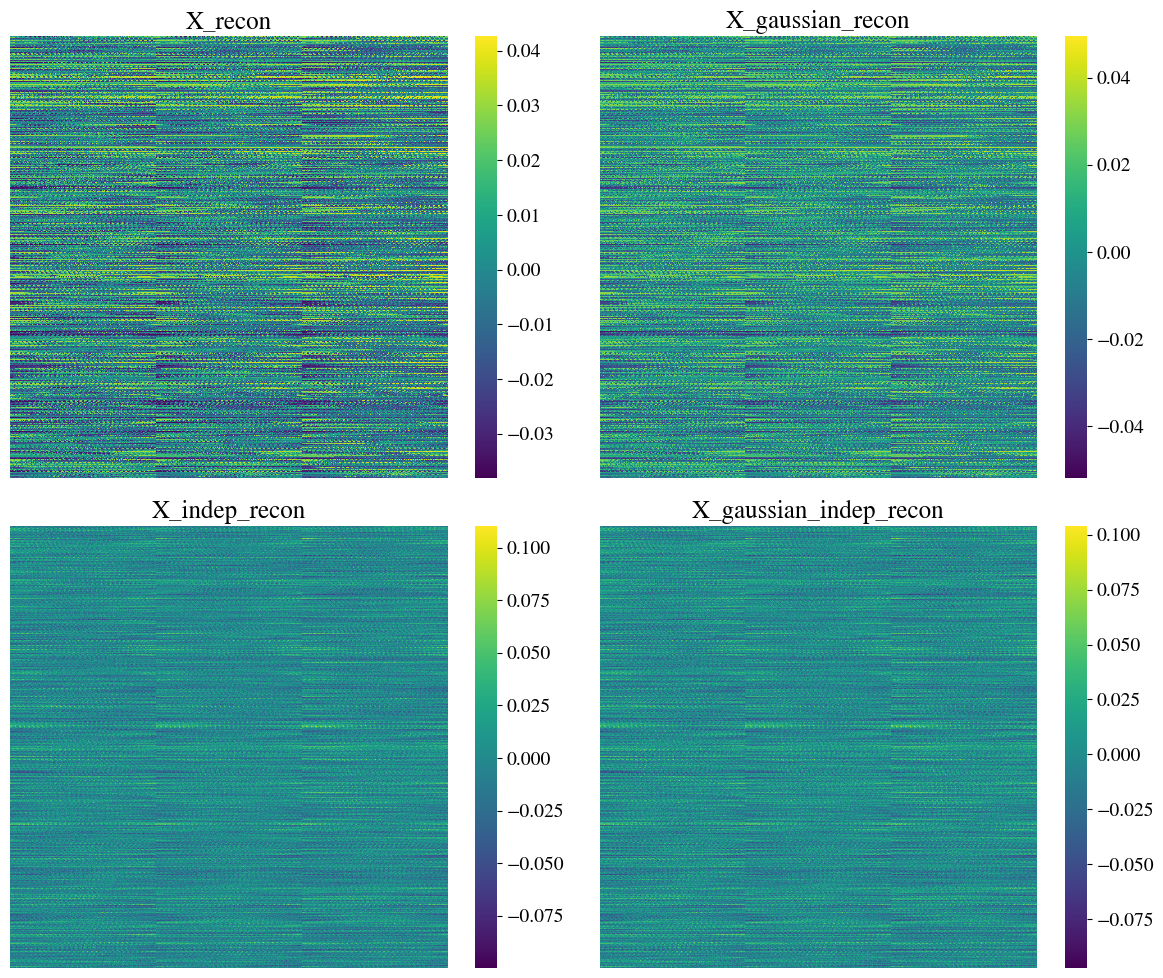

In [ ]:
_ = plot_heatmaps(eigvecs, eigvecs_gaussian, eigvecs_independent, eigvecs_indep_gaussian, Vt)

In [ ]:
kerneltype = GaussianKernel
kernel_width = 4
classes = None
n_train = 10000
top_fra_eigmode = 3000
n_test = 1

X_train, y_train, _, _ = get_train_test_dataset(n_train, n_test, "cifar100", classes=classes,
                                                       center=True, normalize=False)
X_train = ensure_torch(X_train)
full_dict = full_analysis(X_train, kerneltype, kernel_width, top_fra_eigmode)
normeigvals = full_dict["Normal"]["eigvals"].cpu().numpy()[:10]
gaussianeigvals = full_dict["Gaussian"]["eigvals"].cpu().numpy()[:10]
independenteigvals = full_dict["Independent"]["eigvals"].cpu().numpy()[:10]
gaussianindependenteigvals = full_dict["Gaussian Independent"]["eigvals"].cpu().numpy()[:10]
print(f"Normal: {normeigvals}")
print(f"Gaussianized data: {gaussianeigvals}")
print(f"Independentized data: {independenteigvals}")
print(f"Gaussian independent: {gaussianindependenteigvals}")

Normal: [0.94024367 0.01885925 0.00544311 0.00406942 0.0033232  0.00208671
 0.00172024 0.00120722 0.00108069 0.00099948]
Gaussianized data: [0.94013227 0.01890884 0.00544766 0.00411208 0.00331168 0.00209523
 0.00172814 0.00121139 0.00108868 0.00100361]
Independentized data: [0.94021141 0.01899002 0.00533892 0.0040757  0.00325842 0.00215979
 0.00174271 0.00121135 0.00106405 0.00101561]
Gaussian independent: [0.94011879 0.0188487  0.00541347 0.00409053 0.00332794 0.00209048
 0.00173308 0.00121624 0.00109185 0.00100941]


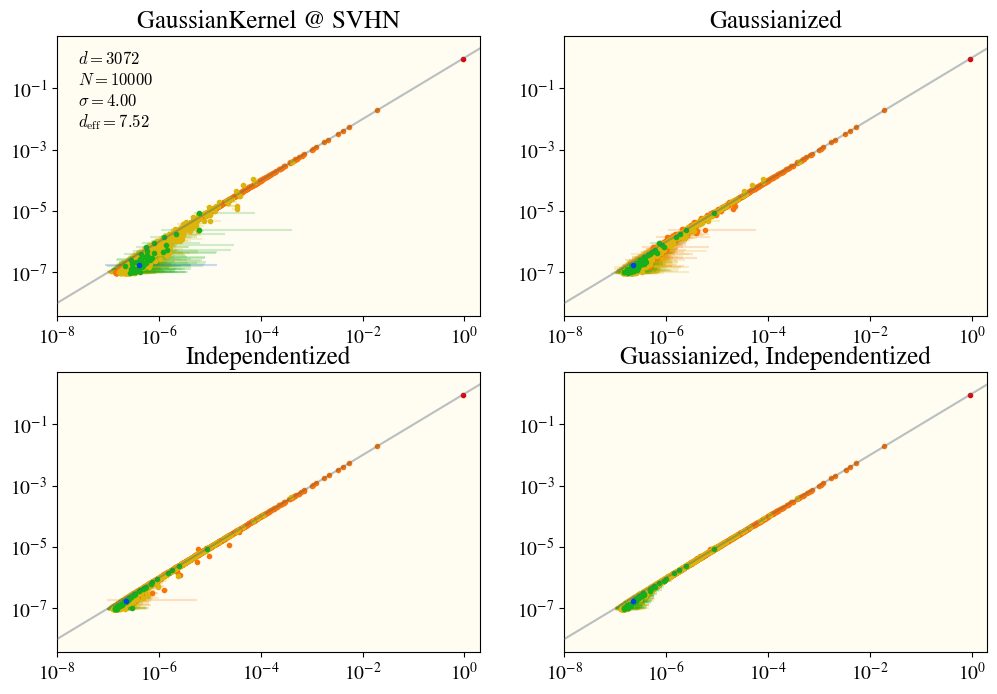

In [ ]:
N, d = X_train.shape
degrees = [monomial.degree() for monomial in full_dict["Normal"]["monomials"]]
colors=['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# eigvals_cpu = eigvals.cpu().numpy()
# eigvals_g_cpu = eigvals_g.cpu().numpy()
# eigvals_i_cpu = eigvals_i.cpu().numpy()
# eigvals_gi_cpu = eigvals_gi.cpu().numpy()
quartiles = full_dict["Normal"]["quartiles"]
quartiles_g = full_dict["Gaussian"]["quartiles"]
quartiles_i = full_dict["Independent"]["quartiles"]
quartiles_gi = full_dict["Gaussian Independent"]["quartiles"]
eff_eigvals = quartiles[:, 1]
eff_eigvals_g = quartiles_g[:, 1]
eff_eigvals_i = quartiles_i[:, 1]
eff_eigvals_gi = quartiles_gi[:, 1]
xerr = -np.array([quartiles[:, 0]-eff_eigvals, eff_eigvals-quartiles[:, 2]])
xerr_g = -np.array([quartiles_g[:, 0]-eff_eigvals_g, eff_eigvals_g-quartiles_g[:, 2]])
xerr_i = -np.array([quartiles_i[:, 0]-eff_eigvals_i, eff_eigvals_i-quartiles_i[:, 2]])
xerr_gi = -np.array([quartiles_gi[:, 0]-eff_eigvals_gi, eff_eigvals_gi-quartiles_gi[:, 2]])


xmin, xmax = 1e-8, 2e0
xx = np.linspace(xmin, xmax, 10)

def plot_eigvals(ax, eff_eigvals, fra_eigvals, xerr):
    for degree in np.unique(degrees):
        idxs = np.where(np.array(degrees) == degree)[0]
        markers, caps, bars = ax.errorbar(eff_eigvals[idxs], fra_eigvals[idxs], xerr=xerr[:, idxs],
                    color=colors[degree%7], linestyle='', marker='.', alpha=1,)
        [bar.set_alpha(0.2) for bar in bars]

    ax.set_xlim(xmin, xmax)
    ax.plot(xx, xx, color='xkcd:slate', alpha=0.4, zorder=4)
    ax.set_xscale('log')
    ax.set_yscale('log')

plot_eigvals(axes[0, 0], eff_eigvals, full_dict["Normal"]["fra_eigvals"], xerr)
plot_eigvals(axes[0, 1], eff_eigvals_g, full_dict["Gaussian"]["fra_eigvals"], xerr_g)
plot_eigvals(axes[1, 0], eff_eigvals_i, full_dict["Independent"]["fra_eigvals"], xerr_i)
plot_eigvals(axes[1, 1], eff_eigvals_gi, full_dict["Gaussian Independent"]["fra_eigvals"], xerr_gi)


d_eff = (full_dict["Normal"]["data_eigvals"].sum())**2/(full_dict["Normal"]["data_eigvals"]**2).sum()
ax = axes[0, 0]
ax.set_title(f'GaussianKernel @ CIFAR100')
text_kwargs = {'fontsize': 12, 'transform': ax.transAxes}
ax.text(0.05, 0.9, f'$d={d}$', **text_kwargs)
ax.text(0.05, 0.825, f'$N={N}$', **text_kwargs)
ax.text(0.05, 0.75, f'$\sigma={kernel_width:.2f}$', **text_kwargs)
ax.text(0.05, 0.675, f'$d_\mathrm{{eff}}={d_eff:.2f}$', **text_kwargs)
axes[0, 1].set_title(f'Gaussianized')
axes[1, 0].set_title(f'Independentized')
axes[1, 1].set_title(f'Guassianized, Independentized')
plt.show()

## ImageNet Runs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set path to your tar file in Drive
TAR_PATH = "/content/drive/MyDrive/ILSVRC2012_img_val.tar"

Mounted at /content/drive


## Tabular Data

### Phishing URLs

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

splits = {'train': 'data/train.parquet', 'test': 'data/test.parquet'}
phishing_websites = pd.read_parquet("hf://datasets/pirocheto/phishing-url/" + splits["train"]).to_numpy()

X_train = torch.tensor(np.astype(phishing_websites[:, 1:-1], np.float32)).cuda()

X_mean = reduce(X_train, 'N d -> d', 'mean')
X_train -= X_mean
X_norm = X_train.std(axis=0)
X_norm[X_norm == 0] = 1
X_train /= X_norm[None, :]

S = torch.linalg.svdvals(X_train)
X_train /= torch.sqrt((S**2).sum())
X_train = ensure_torch(X_train)
del S

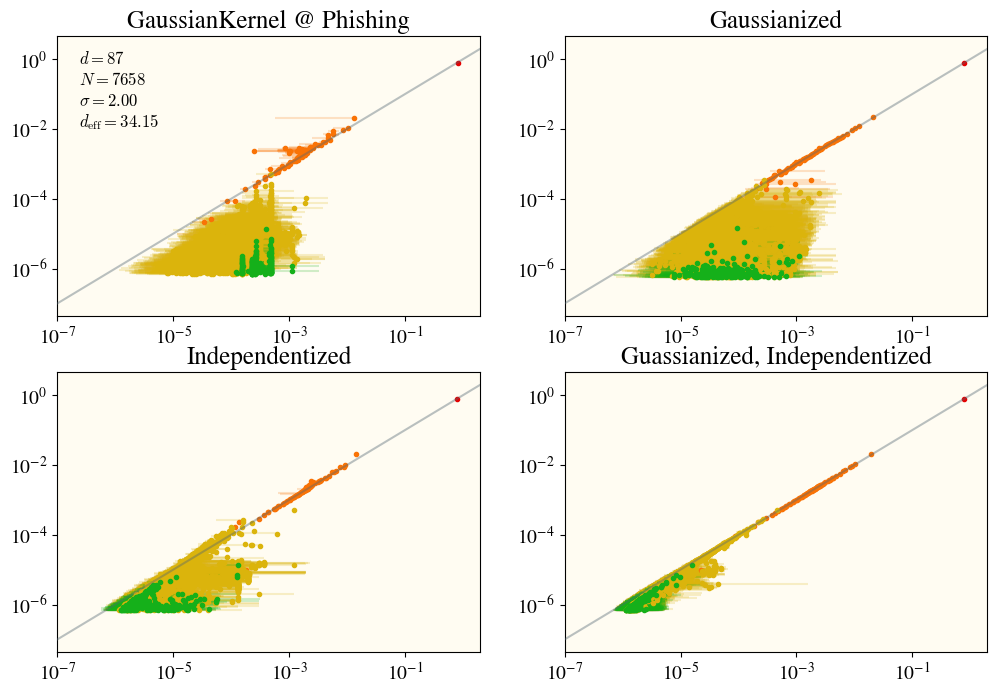

In [ ]:
full_dict = full_analysis(X_train, GaussianKernel, 2, top_fra_eigmode=3000)

N, d = X_train.shape
degrees = [monomial.degree() for monomial in full_dict["Normal"]["monomials"]]
colors=['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# eigvals_cpu = eigvals.cpu().numpy()
# eigvals_g_cpu = eigvals_g.cpu().numpy()
# eigvals_i_cpu = eigvals_i.cpu().numpy()
# eigvals_gi_cpu = eigvals_gi.cpu().numpy()
quartiles = full_dict["Normal"]["quartiles"]
quartiles_g = full_dict["Gaussian"]["quartiles"]
quartiles_i = full_dict["Independent"]["quartiles"]
quartiles_gi = full_dict["Gaussian Independent"]["quartiles"]
eff_eigvals = quartiles[:, 1]
eff_eigvals_g = quartiles_g[:, 1]
eff_eigvals_i = quartiles_i[:, 1]
eff_eigvals_gi = quartiles_gi[:, 1]
xerr = -np.array([quartiles[:, 0]-eff_eigvals, eff_eigvals-quartiles[:, 2]])
xerr_g = -np.array([quartiles_g[:, 0]-eff_eigvals_g, eff_eigvals_g-quartiles_g[:, 2]])
xerr_i = -np.array([quartiles_i[:, 0]-eff_eigvals_i, eff_eigvals_i-quartiles_i[:, 2]])
xerr_gi = -np.array([quartiles_gi[:, 0]-eff_eigvals_gi, eff_eigvals_gi-quartiles_gi[:, 2]])


xmin, xmax = 1e-7, 2e0
xx = np.linspace(xmin, xmax, 10)

def plot_eigvals(ax, eff_eigvals, fra_eigvals, xerr):
    for degree in np.unique(degrees):
        idxs = np.where(np.array(degrees) == degree)[0]
        markers, caps, bars = ax.errorbar(eff_eigvals[idxs], fra_eigvals[idxs], xerr=xerr[:, idxs],
                    color=colors[degree%7], linestyle='', marker='.', alpha=1,)
        [bar.set_alpha(0.2) for bar in bars]

    ax.set_xlim(xmin, xmax)
    ax.plot(xx, xx, color='xkcd:slate', alpha=0.4, zorder=4)
    ax.set_xscale('log')
    ax.set_yscale('log')

plot_eigvals(axes[0, 0], eff_eigvals, full_dict["Normal"]["fra_eigvals"], xerr)
plot_eigvals(axes[0, 1], eff_eigvals_g, full_dict["Gaussian"]["fra_eigvals"], xerr_g)
plot_eigvals(axes[1, 0], eff_eigvals_i, full_dict["Independent"]["fra_eigvals"], xerr_i)
plot_eigvals(axes[1, 1], eff_eigvals_gi, full_dict["Gaussian Independent"]["fra_eigvals"], xerr_gi)


d_eff = (full_dict["Normal"]["data_eigvals"].sum())**2/(full_dict["Normal"]["data_eigvals"]**2).sum()
ax = axes[0, 0]
ax.set_title(f'GaussianKernel @ Phishing')
text_kwargs = {'fontsize': 12, 'transform': ax.transAxes}
ax.text(0.05, 0.9, f'$d={d}$', **text_kwargs)
ax.text(0.05, 0.825, f'$N={N}$', **text_kwargs)
ax.text(0.05, 0.75, f'$\sigma={2:.2f}$', **text_kwargs)
ax.text(0.05, 0.675, f'$d_\mathrm{{eff}}={d_eff:.2f}$', **text_kwargs)
axes[0, 1].set_title(f'Gaussianized')
axes[1, 0].set_title(f'Independentized')
axes[1, 1].set_title(f'Guassianized, Independentized')
plt.show()

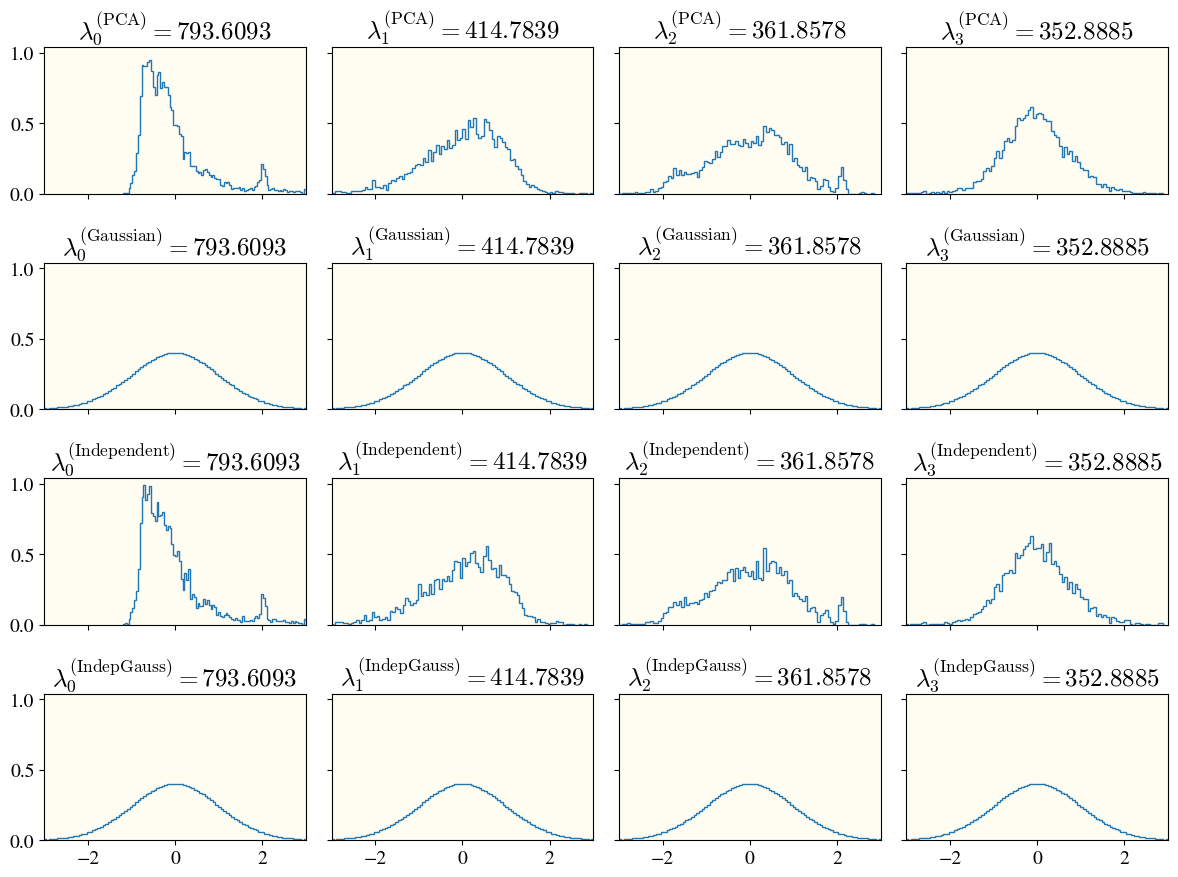

In [ ]:
eigvecs, eigvecs_gaussian, eigvecs_independent, eigvecs_indep_gaussian, Vt = plot_full_pca_distributions(X_train)

### The Shroom

In [ ]:
# !pip install -q datasets
# from datasets import load_dataset

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color", "population", "habitat"
]

mushroom_dataset = pd.read_csv(url, names=columns)

# mushroom_dataset = load_dataset("mstz/mushroom", cache_dir="./local_dataset_cache")["train"].to_pandas()
# mushroom_dataset = mushroom_dataset.drop(columns=["is_poisonous"])

encoder = OneHotEncoder(sparse_output=False)
X_train = encoder.fit_transform(mushroom_dataset)

X_train = torch.tensor(X_train).cuda()

X_mean = reduce(X_train, 'N d -> d', 'mean')
X_train -= X_mean
X_norm = X_train.std(axis=0)
X_norm[X_norm == 0] = 1
X_train /= X_norm[None, :]

S = torch.linalg.svdvals(X_train)
X_train /= torch.sqrt((S**2).sum())
del S

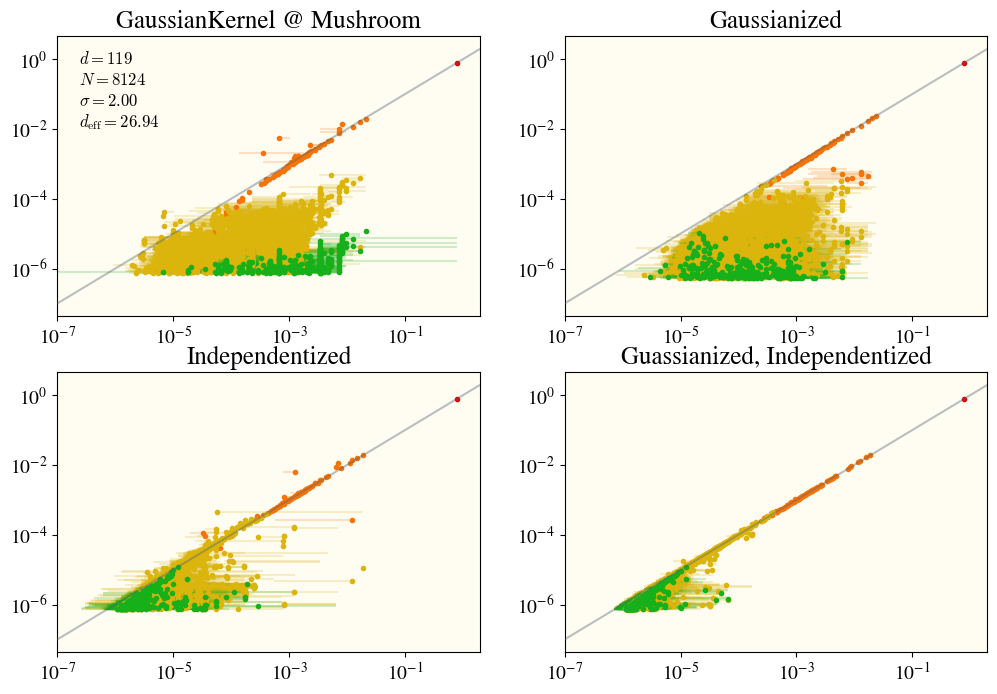

In [ ]:
full_dict = full_analysis(X_train, GaussianKernel, 2, top_fra_eigmode=3000)

N, d = X_train.shape
degrees = [monomial.degree() for monomial in full_dict["Normal"]["monomials"]]
colors=['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# eigvals_cpu = eigvals.cpu().numpy()
# eigvals_g_cpu = eigvals_g.cpu().numpy()
# eigvals_i_cpu = eigvals_i.cpu().numpy()
# eigvals_gi_cpu = eigvals_gi.cpu().numpy()
quartiles = full_dict["Normal"]["quartiles"]
quartiles_g = full_dict["Gaussian"]["quartiles"]
quartiles_i = full_dict["Independent"]["quartiles"]
quartiles_gi = full_dict["Gaussian Independent"]["quartiles"]
eff_eigvals = quartiles[:, 1]
eff_eigvals_g = quartiles_g[:, 1]
eff_eigvals_i = quartiles_i[:, 1]
eff_eigvals_gi = quartiles_gi[:, 1]
xerr = -np.array([quartiles[:, 0]-eff_eigvals, eff_eigvals-quartiles[:, 2]])
xerr_g = -np.array([quartiles_g[:, 0]-eff_eigvals_g, eff_eigvals_g-quartiles_g[:, 2]])
xerr_i = -np.array([quartiles_i[:, 0]-eff_eigvals_i, eff_eigvals_i-quartiles_i[:, 2]])
xerr_gi = -np.array([quartiles_gi[:, 0]-eff_eigvals_gi, eff_eigvals_gi-quartiles_gi[:, 2]])


xmin, xmax = 1e-7, 2e0
xx = np.linspace(xmin, xmax, 10)

def plot_eigvals(ax, eff_eigvals, fra_eigvals, xerr):
    for degree in np.unique(degrees):
        idxs = np.where(np.array(degrees) == degree)[0]
        markers, caps, bars = ax.errorbar(eff_eigvals[idxs], fra_eigvals[idxs], xerr=xerr[:, idxs],
                    color=colors[degree%7], linestyle='', marker='.', alpha=1,)
        [bar.set_alpha(0.2) for bar in bars]

    ax.set_xlim(xmin, xmax)
    ax.plot(xx, xx, color='xkcd:slate', alpha=0.4, zorder=4)
    ax.set_xscale('log')
    ax.set_yscale('log')

plot_eigvals(axes[0, 0], eff_eigvals, full_dict["Normal"]["fra_eigvals"], xerr)
plot_eigvals(axes[0, 1], eff_eigvals_g, full_dict["Gaussian"]["fra_eigvals"], xerr_g)
plot_eigvals(axes[1, 0], eff_eigvals_i, full_dict["Independent"]["fra_eigvals"], xerr_i)
plot_eigvals(axes[1, 1], eff_eigvals_gi, full_dict["Gaussian Independent"]["fra_eigvals"], xerr_gi)


d_eff = (full_dict["Normal"]["data_eigvals"].sum())**2/(full_dict["Normal"]["data_eigvals"]**2).sum()
ax = axes[0, 0]
ax.set_title(f'GaussianKernel @ Mushroom')
text_kwargs = {'fontsize': 12, 'transform': ax.transAxes}
ax.text(0.05, 0.9, f'$d={d}$', **text_kwargs)
ax.text(0.05, 0.825, f'$N={N}$', **text_kwargs)
ax.text(0.05, 0.75, f'$\sigma={2:.2f}$', **text_kwargs)
ax.text(0.05, 0.675, f'$d_\mathrm{{eff}}={d_eff:.2f}$', **text_kwargs)
axes[0, 1].set_title(f'Gaussianized')
axes[1, 0].set_title(f'Independentized')
axes[1, 1].set_title(f'Guassianized, Independentized')
plt.show()

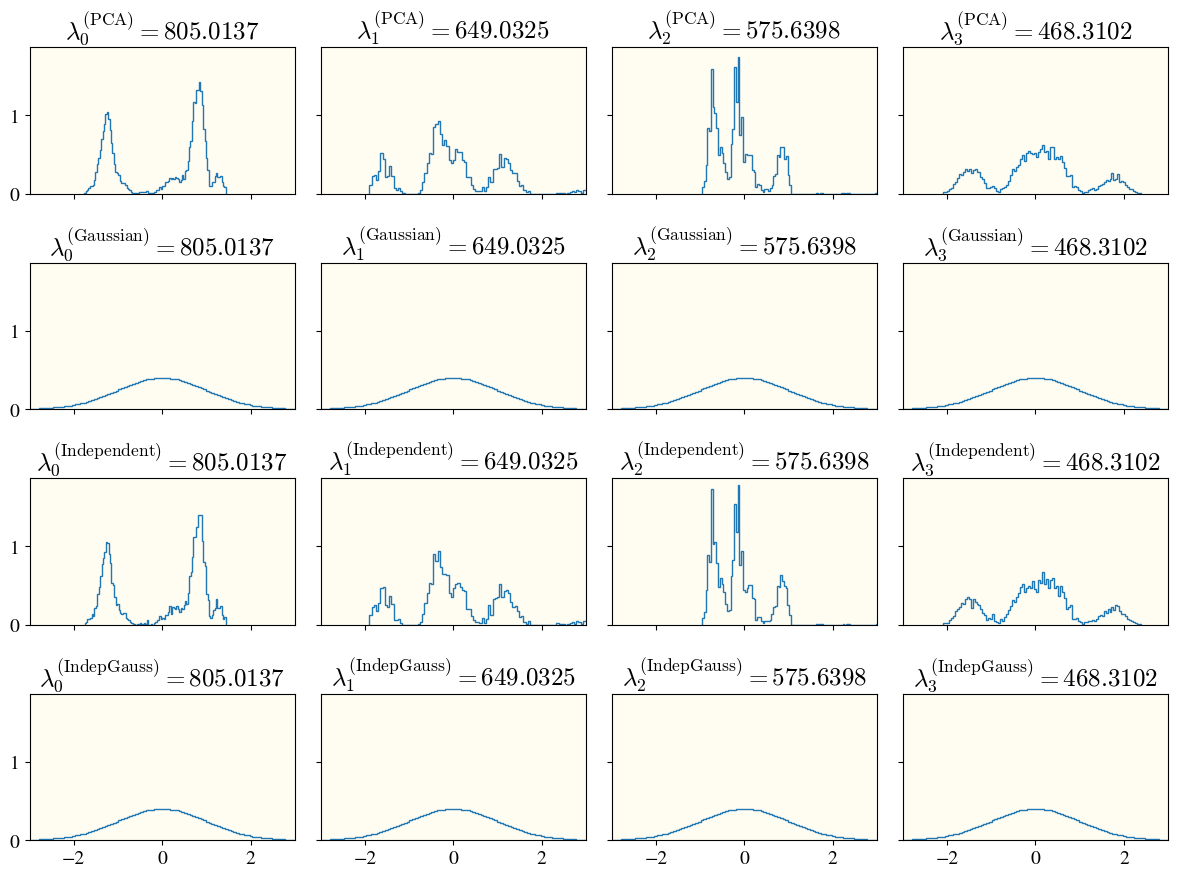

In [ ]:
eigvecs, eigvecs_gaussian, eigvecs_independent, eigvecs_indep_gaussian, Vt = plot_full_pca_distributions(X_train)

### Diabetus

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

splits = {'train': 'train_20.csv', 'test': 'test_20.csv'}
cdc_dataset = pd.read_csv("hf://datasets/naabiil/CDC_Diabetes_Health_Indicators/" + splits["train"])

X_train = ensure_torch(torch.tensor(np.astype(cdc_dataset.to_numpy(), np.float32)).cuda())
X_train = X_train[:15000, :]

X_mean = reduce(X_train, 'N d -> d', 'mean')
X_train -= X_mean
X_norm = X_train.std(axis=0)
X_norm[X_norm == 0] = 1
X_train /= X_norm[None, :]

S = torch.linalg.svdvals(X_train)
X_train /= torch.sqrt((S**2).sum())
del S

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


torch.Size([15000, 22])


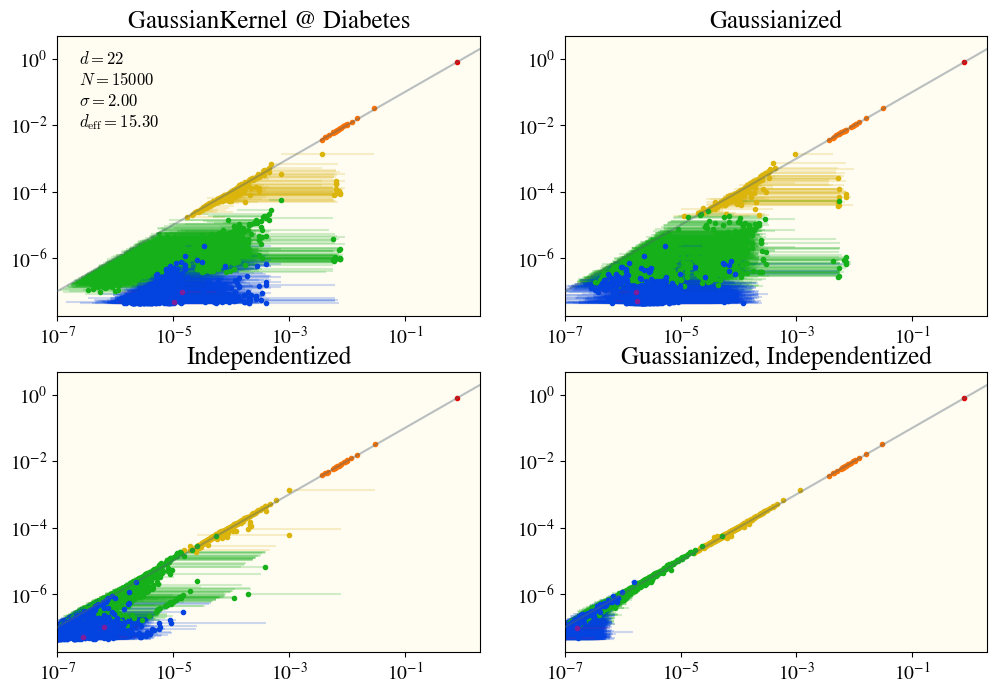

In [ ]:
full_dict = full_analysis(X_train, GaussianKernel, 2, top_fra_eigmode=3000)

N, d = X_train.shape
degrees = [monomial.degree() for monomial in full_dict["Normal"]["monomials"]]
colors=['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# eigvals_cpu = eigvals.cpu().numpy()
# eigvals_g_cpu = eigvals_g.cpu().numpy()
# eigvals_i_cpu = eigvals_i.cpu().numpy()
# eigvals_gi_cpu = eigvals_gi.cpu().numpy()
quartiles = full_dict["Normal"]["quartiles"]
quartiles_g = full_dict["Gaussian"]["quartiles"]
quartiles_i = full_dict["Independent"]["quartiles"]
quartiles_gi = full_dict["Gaussian Independent"]["quartiles"]
eff_eigvals = quartiles[:, 1]
eff_eigvals_g = quartiles_g[:, 1]
eff_eigvals_i = quartiles_i[:, 1]
eff_eigvals_gi = quartiles_gi[:, 1]
xerr = -np.array([quartiles[:, 0]-eff_eigvals, eff_eigvals-quartiles[:, 2]])
xerr_g = -np.array([quartiles_g[:, 0]-eff_eigvals_g, eff_eigvals_g-quartiles_g[:, 2]])
xerr_i = -np.array([quartiles_i[:, 0]-eff_eigvals_i, eff_eigvals_i-quartiles_i[:, 2]])
xerr_gi = -np.array([quartiles_gi[:, 0]-eff_eigvals_gi, eff_eigvals_gi-quartiles_gi[:, 2]])


xmin, xmax = 1e-7, 2e0
xx = np.linspace(xmin, xmax, 10)

def plot_eigvals(ax, eff_eigvals, fra_eigvals, xerr):
    for degree in np.unique(degrees):
        idxs = np.where(np.array(degrees) == degree)[0]
        markers, caps, bars = ax.errorbar(eff_eigvals[idxs], fra_eigvals[idxs], xerr=xerr[:, idxs],
                    color=colors[degree%7], linestyle='', marker='.', alpha=1,)
        [bar.set_alpha(0.2) for bar in bars]

    ax.set_xlim(xmin, xmax)
    ax.plot(xx, xx, color='xkcd:slate', alpha=0.4, zorder=4)
    ax.set_xscale('log')
    ax.set_yscale('log')

plot_eigvals(axes[0, 0], eff_eigvals, full_dict["Normal"]["fra_eigvals"], xerr)
plot_eigvals(axes[0, 1], eff_eigvals_g, full_dict["Gaussian"]["fra_eigvals"], xerr_g)
plot_eigvals(axes[1, 0], eff_eigvals_i, full_dict["Independent"]["fra_eigvals"], xerr_i)
plot_eigvals(axes[1, 1], eff_eigvals_gi, full_dict["Gaussian Independent"]["fra_eigvals"], xerr_gi)


d_eff = (full_dict["Normal"]["data_eigvals"].sum())**2/(full_dict["Normal"]["data_eigvals"]**2).sum()
ax = axes[0, 0]
ax.set_title(f'GaussianKernel @ Diabetes')
text_kwargs = {'fontsize': 12, 'transform': ax.transAxes}
ax.text(0.05, 0.9, f'$d={d}$', **text_kwargs)
ax.text(0.05, 0.825, f'$N={N}$', **text_kwargs)
ax.text(0.05, 0.75, f'$\sigma={2:.2f}$', **text_kwargs)
ax.text(0.05, 0.675, f'$d_\mathrm{{eff}}={d_eff:.2f}$', **text_kwargs)
axes[0, 1].set_title(f'Gaussianized')
axes[1, 0].set_title(f'Independentized')
axes[1, 1].set_title(f'Guassianized, Independentized')
plt.show()

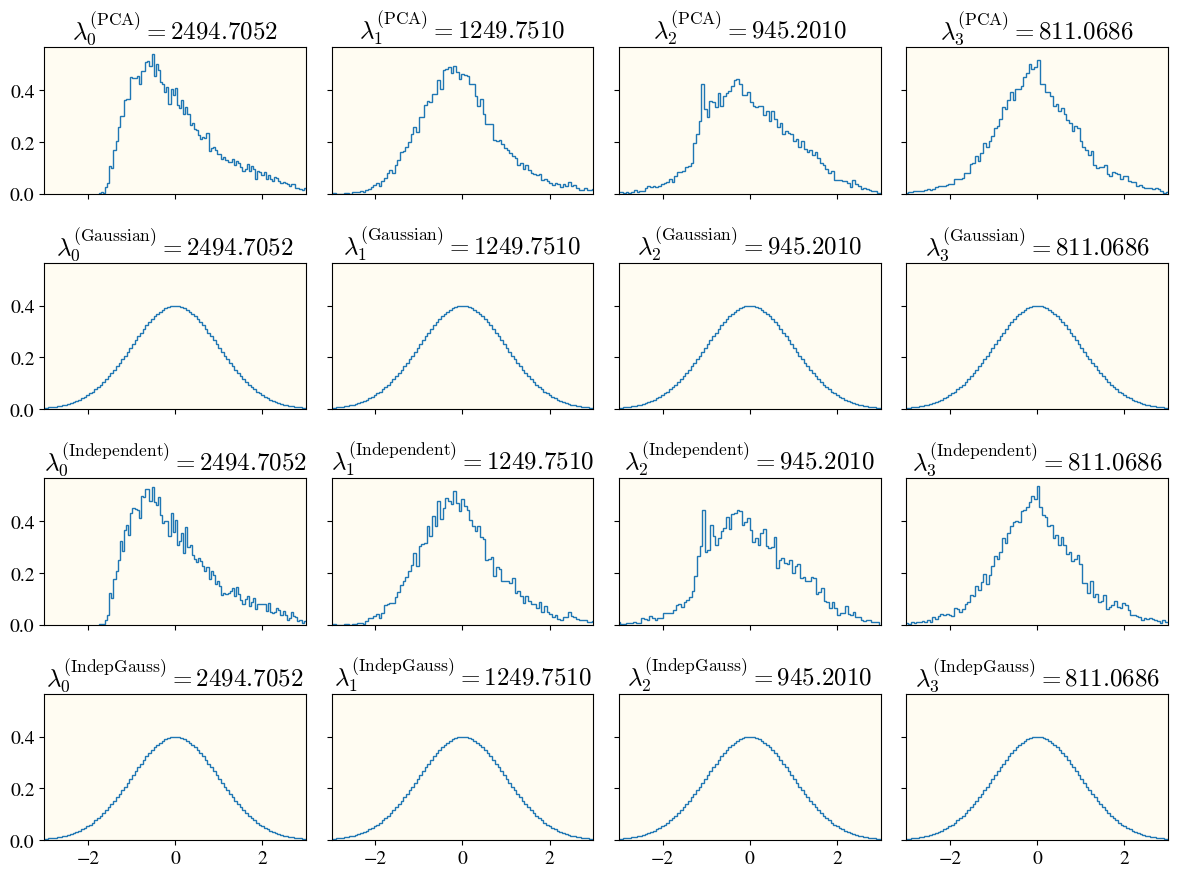

In [ ]:
eigvecs, eigvecs_gaussian, eigvecs_independent, eigvecs_indep_gaussian, Vt = plot_full_pca_distributions(X_train)

## Scratch

In [ ]:
import numpy as np
from scipy.stats import norm

def get_emperical_pdf(X, num_bins=100, tol=1e-3):
    counts, bin_edges = np.histogram(X, bins=num_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]
    pdf = counts * bin_width
    assert np.abs(np.cumsum(pdf)[-1]-1) <= tol, f"PDF estimator is outside of tolderance {tol} away from area 1"
    return bin_centers, pdf

def get_emperical_cdf(X):
    ranks = np.argsort(np.argsort(X, axis=0), axis=0)
    uniform = (ranks + 1) / (X.shape[0] + 1)
    return uniform #uniform distribution while preserving the relative rank

def cdf_to_gaussian(uniform_cdf, S):
    gaussian_samples = norm.ppf(uniform_cdf) * S
    return gaussian_samples

def sample_from_cdf(cdf, num_samples=10000):
    uniform_samples = np.random.rand(num_samples)

    bin_indices = np.searchsorted(cdf, uniform_samples)

    bin_left_edges = bin_edges[bin_indices]
    bin_right_edges = bin_edges[bin_indices + 1]
    random_within_bin = np.random.rand(num_samples)

    samples = bin_left_edges + random_within_bin * (bin_right_edges - bin_left_edges)
    return samples


def gaussianize_data(X, S=None):
    X = X.cpu().numpy()
    S = S.cpu().numpy()
    uniform = get_emperical_cdf(X)
    gaussian = norm.ppf(uniform)

    if S is not None:
        S = np.asarray(S)
        if S.ndim == 0:
            gaussian *= S  # scalar S
        else:
            gaussian *= S.reshape(1, -1)  # broadcast to columns
    return gaussian


# def gaussianize_data(X, S, to_torch=True):
#     gaussian_data = np.zeros_like(X.cpu().detach())
#     for idx in range(X.shape[1]):
#         Xi, Si = X[:, idx].cpu().numpy(), S[idx].cpu().numpy()
#         cdf = get_emperical_cdf(Xi)
#         gaussian_data[:, idx] = cdf_to_gaussian(cdf, Si)
#     return ensure_torch(gaussian_data) if to_torch else gaussian_data

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmaps(X, gdata, idx1, idx2, plot_axes=None):
    """
    Plots heatmaps for two columns (idx1 and idx2) from two datasets (X and gdata).

    Parameters:
    - X: The original dataset (NumPy array or tensor).
    - gdata: The Gaussianized dataset (NumPy array).
    - idx1: The index of the first column to plot.
    - idx2: The index of the second column to plot.
    - plot_axes: Optional tuple/list of axes (default: None). If given, it uses provided axes for plotting.

    If plot_axes is not provided, it creates a new figure with two subplots.
    """
    # Extract columns
    col1 = X[:, idx1].cpu().numpy() if hasattr(X, 'cpu') else X[:, idx1]
    col2 = X[:, idx2].cpu().numpy() if hasattr(X, 'cpu') else X[:, idx2]

    # Create 2D histogram (heatmap data)
    heatmap_data_1, xedges, yedges = np.histogram2d(col1, col2, bins=100)
    heatmap_data_2, xedges, yedges = np.histogram2d(gdata[:, idx1], gdata[:, idx2], bins=100)

    # Set up plot axes
    if plot_axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    else:
        axes = plot_axes

    # Plot heatmap for normal data
    sns.heatmap(heatmap_data_1.T,
                xticklabels=False,
                yticklabels=False,
                cmap='viridis', ax=axes[0])
    axes[0].set_title("Normal data")

    # Plot heatmap for Gaussianized data
    sns.heatmap(heatmap_data_2.T,
                xticklabels=False,
                yticklabels=False,
                cmap='viridis', ax=axes[1])
    axes[1].set_title("Gaussianized data")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example usage:
plot_heatmaps(X, gdata, idx1=0, idx2=2)  # With default axes
# plot_heatmaps(X, gdata, idx1=1, idx2=2, plot_axes=[plt.gca(), plt.gca()])  # With custom axes


In [ ]:
# for i, ax in enumerate(axes.flatten()):
i=0
# xvar = S[i].item()**2
Xi = X[:, i].cpu().numpy()# / np.sqrt(xvar)
# Xi = Xi[np.abs(Xi) <= 3.1]
counts, bin_edges = np.histogram(Xi, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# ax.set_title(f"$\lambda^\mathrm{{(PCA)}}_{{{i}}}={xvar:.4f}$")
# ax.set_xlim(-3, 3)

bin_width = bin_edges[1] - bin_edges[0]
good_pdf_estimate = np.abs(np.sum(counts * bin_width)-1) <= 0.01
assert good_pdf_estimate, "PDF estimator is significantly away from area 1, retry"
cdf = np.cumsum(counts) * bin_width

In [ ]:
idx = 10
idx2 = 20
plt.hist(gdata[:, idx], bins=100, density=True)
plt.hist(X.cpu().numpy()[:, idx], bins=100, density=True)
plt.show()
(gdata[:, 2] @ gdata[:, 1]), X.cpu().numpy()[:, 2] @ X.cpu().numpy()[:, 1]

In [ ]:
def get_image_dataset(n_train, n_test, dataset_name = 'cifar10', data_dir='data_dir', **kwargs):
    assert dataset_name in ['mnist', 'fmnist', 'cifar10', 'cifar100', 'svhn', 'imagenet32', 'imagenet64'], "Dataset not implemented"
    classes = kwargs.get("classes", None)
    imdata = ImageData(dataset_name, data_dir, classes=classes)
    X_train, y_train = imdata.get_dataset(n_train, get='train', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_test, y_test = imdata.get_dataset(n_train, get='test', centered=kwargs.get("center", False), normalize=kwargs.get("normalize", False))
    X_train, y_train, X_test, y_test = [ensure_torch(t) for t in (X_train, y_train, X_test, y_test)]
    X_train = rearrange(X_train, 'Ntrain c h w -> Ntrain (c h w)')
    X_test = rearrange(X_test, 'Ntest c h w -> Ntest (c h w)')

    return X_train, y_train, X_test, y_test